In [ ]:
from google.colab import files
import io
from pprint import pprint
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, StackingRegressor
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer, MinMaxScaler
from sklearn.compose import ColumnTransformer
import numpy as np
from tabulate import tabulate

%pip install python-pptx

# Step 1: Upload and Load the Dataset
uploaded = files.upload()

for fn in uploaded.keys():
    print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')
    try:
        df_ecological = pd.read_excel(io.BytesIO(uploaded[fn]))
        print("\n--- First Few Rows of the Dataset ---\n")
        print(df_ecological.head())
    except Exception as e:
        print(f"Error reading Excel file: {e}")

# Additional Steps for Analysis
def explore_data(data):
    """Perform exploratory data analysis on the dataset."""
    print("\n--- Dataset Overview ---\n")
    print(data.info())
    print("\n--- Summary Statistics ---\n")
    print(data.describe())

# Example of EDA
try:
    explore_data(df_ecological)
except NameError:
    print("Dataset not loaded. Please check the uploaded file.")


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 5.8 MB/s eta 0:00:00


Saving Ecological_characterization_Hanna_Markle.xlsx to Ecological_characterization_Hanna_Markle.xlsx
User uploaded file "Ecological_characterization_Hanna_Markle.xlsx" with length 176593 bytes

--- First Few Rows of the Dataset ---

  population   latitude  longitude  Elevation        MAT      MCMT  \
0     AMBR-A  43.733229   1.823869        136  10.763636  0.154545   
1     ANGE-A  43.911999   1.656649        169  10.536364  0.081818   
2     ANGE-B  43.912140   1.656855        168  10.545455  0.081818   
3     AULO-A  43.190552   0.815774        339  10.081818 -0.072727   
4     AURE-B  43.477976   1.452214        197  10.609091  0.190909   

       PPT_wt     PPT_sp     PPT_sm      PPT_at  ...  plant_OTU203  \
0  128.909091  70.181818  77.636364  171.545455  ...             0   
1  127.272727  70.636364  85.727273  172.181818  ...             0   
2  127.272727  70.636364  85.727273  172.181818  ...             0   
3  117.090909  75.454545  92.181818  186.363636  ...             

In [ ]:
#READ THE OTUs ASSOCIATED WITH PATHOGENS
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  try:
    df_gyrb = pd.read_excel(io.BytesIO(uploaded[fn]))
    #print(df_gyrb)
  except Exception as e:
    print(f"Error reading Excel file: {e}")


Saving gyrb_fragment_dataset1.xlsx to gyrb_fragment_dataset1.xlsx
User uploaded file "gyrb_fragment_dataset1.xlsx" with length 17492 bytes


In [ ]:
# READ RELATIVE ABUNDANCE INFO
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  try:
    df_otu_abundance = pd.read_excel(io.BytesIO(uploaded[fn]))
    #print(df_otu_abundance)
  except Exception as e:
    print(f"Error reading Excel file: {e}")


Saving Leaf_and_Root_OTU_Relative_Abundance.xlsx to Leaf_and_Root_OTU_Relative_Abundance.xlsx
User uploaded file "Leaf_and_Root_OTU_Relative_Abundance.xlsx" with length 99478 bytes


In [ ]:
class EcodynamicsAI:
    def __init__(self, data_path=""):
        """Initialize the framework with the dataset path."""
        self.data_path = data_path

        self.data = None
        # self.load_data()

        self.target = None
        self.features = None

        self.otu_data = None
        # self.load_otu_data()


    def load_data(self):
        """Load and preview the dataset."""
        #self.data = pd.ExcelFile(self.data_path).parse(sheet_name=0)
        self.data = df_ecological
        if self.data is None:
            raise ValueError("Dataset not loaded. Please check the data path.")


        if self.data.index.name != 'population' and 'population' in self.data.columns:
          self.data.set_index('population', inplace=True)

        # Check for '.' values
        # self.find_dot_values(self.data, dataset_name="Data")


        # Replace '.' with NaN
        self.data = self.data.replace('.', np.nan)


        # Explicitly convert object columns to numeric where possible
        # self.data = self.data.apply(lambda col: pd.to_numeric(col, errors='coerce') if col.dtypes == 'object' else col)

        # Explicitly convert only numeric-looking columns to numeric
        # for col in self.data.columns:
        #     if self.data[col].dtype == 'object':  # Check if column is object type
        #         try:
        #             # Attempt numeric conversion
        #             self.data[col] = pd.to_numeric(self.data[col], errors='coerce')
        #         except Exception as e:
        #               print(f"Error converting column {col}: {e}")

        print(f"Dataset Loaded Successfully. {self.data.shape}")
        # print("\n--- First Few Rows ---\n")
        # print(self.data.head())


    def load_otu_data(self):
        """Load, preprocess, and CLR-transform OTU relative abundance data."""
        self.otu_data = df_otu_abundance

        if self.otu_data is None:
            raise ValueError("Dataset otu data not loaded. Please check the data path.")

        if self.otu_data.index.name != 'population' and 'population' in self.otu_data.columns:
          self.otu_data.set_index('population', inplace=True)

        # Check for '.' values
        # self.find_dot_values(self.otu_data, dataset_name="OTU Data")

        self.otu_data = self.otu_data.replace('.', np.nan)
        #self.otu_data = self.otu_data.apply(lambda col: pd.to_numeric(col, errors='coerce') if col.dtypes == 'object' else col)

        print(f"OTU Data Loaded Successfully., {self.otu_data.shape}")
        # print("\n--- First Few Rows of OTU Data ---\n")
        # print(self.otu_data.head())

        # Perform CLR transformation on leaf and root OTU columns
        leaf_otus = [col for col in self.otu_data.columns if col.startswith('leaf_Otu')]
        root_otus = [col for col in self.otu_data.columns if col.startswith('root_Otu')]

        print(f"Number of leaf_OTUs in OTU data: {len(leaf_otus)}")
        print(f"Number of root_OTUs in OTU data: {len(root_otus)}")

        def clr_transformation(df, pseudocount=1e-6):
            """Perform CLR transformation on a DataFrame."""
            if (df <= 0).any().any():
                print(f"Warning: Some values are <= 0. Adding pseudocount {pseudocount}.")
                df = df + pseudocount  # Avoid log(0) issues

            # Calculate geometric mean for each sample (row)
            geometric_mean = df.apply(lambda row: np.exp(np.log(row).mean()), axis=1)

            # Apply CLR transformation
            clr_df = df.apply(lambda row: np.log(row / geometric_mean[row.name]), axis=1)

            return clr_df

        # Apply CLR transformation to leaf and root OTUs
        self.otu_data[leaf_otus] = clr_transformation(self.otu_data[leaf_otus])
        self.otu_data[root_otus] = clr_transformation(self.otu_data[root_otus])

        # print("\n--- First Few Rows of OTU Data (After CLR Transformation) ---\n")
        # print(self.otu_data[leaf_otus + root_otus].head())


    def validate_abundance_by_tissue(self):
        """Check if relative abundance is tissue-specific or aggregated."""
        if self.otu_data is None:
            print("OTU data is not loaded.")
            return

        # Analyze column structure
        leaf_otus = [col for col in self.otu_data.columns if col.startswith('leaf_Otu')]
        root_otus = [col for col in self.otu_data.columns if col.startswith('root_Otu')]

        print(f"Number of leaf_OTUs: {len(leaf_otus)}")
        print(f"Number of root_OTUs: {len(root_otus)}")

        if leaf_otus and root_otus:
            print("Relative abundance data is tissue-specific (leaf and root).")
        else:
            print("Relative abundance data may be aggregated or improperly labeled.")

        # Check compositional nature within tissue
        if leaf_otus:
            leaf_sums = self.otu_data[leaf_otus].sum(axis=1)
            print(f"Sum of relative abundances in leaf tissue (sample of sums):")
            print(leaf_sums.head())
        if root_otus:
            root_sums = self.otu_data[root_otus].sum(axis=1)
            print(f"Sum of relative abundances in root tissue (sample of sums):")
            print(root_sums.head())


    def export_data_to_excel(self, output_path):
        """Export self.data to an Excel file."""
        if self.data is not None:
            self.data.to_excel(output_path, index=False)
            print(f"Data exported successfully to {output_path}")
        else:
            print("Data is empty. Nothing to export.")


    def show_missing_values(self):
        """Display the percentage of missing values per column and per row."""
        if self.data is not None:
            # Percentage of missing values per column
            missing_per_column = self.data.isnull().mean() * 100
            print("\n--- Percentage of Missing Values Per Column ---")
            print(missing_per_column[missing_per_column > 0].sort_values(ascending=False))

            # Percentage of missing values per row
            missing_per_row = self.data.isnull().mean(axis=1) * 100
            print("\n--- Percentage of Missing Values Per Row ---")
            print(missing_per_row[missing_per_row > 0].sort_values(ascending=False).head(10))
        else:
            print("Data is empty. Cannot compute missing values.")


    # Output
    #--- Percentage of Missing Values Per Column ---
    # plant_pcoa3        13.207547
    # plant_OTU109       13.207547
    # plant_OTU88        13.207547
    # plant_OTU87        13.207547
    # plant_OTU78        13.207547
    #                      ...
    # leaf_Otu0000058     1.886792
    # leaf_Otu0000057     1.886792
    # leaf_Otu0000052     1.886792
    # leaf_Otu0000051     1.886792
    # leaf_Otu0000179     1.886792
    # Length: 125, dtype: float64

    # --- Percentage of Missing Values Per Row ---
    # 158    37.055838
    # 129    37.055838
    # 66     37.055838
    # 90     26.395939
    # 8      24.873096
    # 105    24.873096
    # 88     24.873096
    # 85     24.873096
    # 83     24.873096
    # 80     24.873096



    #Check if this is correct
    def find_dot_values(self, dataset, dataset_name="Dataset"):
        """Identify rows containing '.' and count occurrences."""
        dot_counts = (dataset == '.').sum(axis=1)  # Count '.' values per row
        rows_with_dots = dataset[dot_counts > 0]  # Filter rows with at least one '.'

        print(f"\n--- {dataset_name}: Rows with '.' values ---")
        print(f"Number of rows with '.' values: {len(rows_with_dots)}")
        print(f"Sample rows with '.' values:")
        print(rows_with_dots.head())

        return rows_with_dots


    def categorize_features(self):
        """Categorize features into predefined groups, including OTU relative abundances."""
        self.feature_categories = {
            'environmental': [
                'latitude', 'longitude', 'Elevation', 'MAT', 'MCMT', 'PPT_wt', 'PPT_sp', 'PPT_sm', 'PPT_at',
                'Nitrogen', 'CN', 'pH', 'Phosphore', 'Calcium', 'Magnesium', 'Sodium', 'Potassium', 'Iron',
                'Aluminium', 'WHC', 'OC', 'SOM', 'Manganese'
            ],
            'leaf_otus': [col for col in self.data.columns if col.startswith('leaf_Otu')],
            'root_otus': [col for col in self.data.columns if col.startswith('root_Otu')],
            'plant_otus': [col for col in self.data.columns if col.startswith('plant_OTU')],
            'specific_metrics': [
                'richness_microbiota_leaf', 'Shannon_microbiota_leaf',
                'richness_microbiota_root', 'Shannon_microbiota_root',
                'richness_pathobiota_leaf', 'Shannon_pathobiota_leaf',
                'richness_pathobiota_root', 'Shannon_pathobiota_root'
            ],
            'plant_metrics': [
                'plant_richness', 'plant_Shannon'
            ]
        }

        # if self.otu_data is not None:
        #     # Replace leaf and root OTU columns with relative abundance data
        #     self.feature_categories['leaf_otus'] = [col for col in self.otu_data.columns if col.startswith('leaf_OTU')]
        #     self.feature_categories['root_otus'] = [col for col in self.otu_data.columns if col.startswith('root_OTU')]

        for category, features in self.feature_categories.items():
            print(f"Category '{category}' has {len(features)} features.")

        total_features = sum(len(features) for features in self.feature_categories.values())
        total_data_points = len(self.data)

        print(f"Total features: {total_features}")
        print(f"Number of data points: {total_data_points}")


    def filter_columns_of_interest(self):

      # - filter the self.data data frame with only the columns of interes all the environmental variables all the leaf otus and root otus,
      # - the microbiota richness and shannon in root and leaf, the pathobiota richness and shannon in root and leaf, the plant OTUs, plant richness
      # and plant shannon, and print out the columns that are discarding and not including
        """Filter the dataset to retain only the columns of interest."""
        columns_of_interest = (
            self.feature_categories['environmental'] +
            self.feature_categories['leaf_otus'] +
            self.feature_categories['root_otus'] +
            self.feature_categories['specific_metrics'] +
            self.feature_categories['plant_otus'] +
            self.feature_categories['plant_metrics']
        )

        retained_columns = [col for col in columns_of_interest if col in self.data.columns]
        discarded_columns = [col for col in self.data.columns if col not in retained_columns]

        print(f"Retaining {len(retained_columns)} columns.")
        print(f"Discarding {len(discarded_columns)} columns.")
        print("\n--- Discarded Columns ---\n")
        print(discarded_columns)

        # Filter the data
        self.data = self.data[retained_columns]


    def validate_and_assign_otu_data(self):
        """Validate and replace OTU data, ensuring all columns and populations are correctly handled."""
        if self.otu_data is not None:


            # Validate common indices (populations)
            common_populations = self.data.index.intersection(self.otu_data.index)
            if len(common_populations) == 0:
                raise ValueError("No matching populations found between data and OTU data.")

            # Filter both dataframes to retain only the common indices
            self.data = self.data.loc[common_populations]
            self.otu_data = self.otu_data.loc[common_populations]

            print(f"Data dimensions after aligning populations: {self.data.shape}")

            # Replace OTU columns in self.data with values from self.otu_data
            leaf_otus = [col for col in self.otu_data.columns if col.startswith('leaf_Otu')]
            root_otus = [col for col in self.otu_data.columns if col.startswith('root_Otu')]

            for col in leaf_otus + root_otus:
                if col in self.otu_data.columns:
                    self.data[col] = self.otu_data[col]

            print(f"Data dimensions after assigning OTU data: {self.data.shape}")
            # print("Sample of assigned leaf_OTU values:")
            # print(self.data[leaf_otus].head())
            # print("Sample of assigned root_OTU values:")
            # print(self.data[root_otus].head())


    def select_target_and_features(self, target_column, feature_categories=None):
        """Select target variable and feature set by category."""
        if target_column not in self.data.columns:
            raise ValueError(f"Target column '{target_column}' not found in dataset.")
        target = target_column

        if feature_categories:
            selected_features = []
            for category in feature_categories:
                if category in self.feature_categories:
                    selected_features.extend(self.feature_categories[category])
                else:
                    raise ValueError(f"Feature category '{category}' not defined.")
            features = selected_features
        else:
            features = [col for col in self.data.columns if col != self.target]

        print(f"Target column set to: {target}")
        print(f"Feature columns selected: {features}")

        return target, features


    def impute_or_drop(self, X, y, strategy='impute'):
        """Handle missing values in the dataset without contaminating the test set."""

        valid_rows = ~y.isna()
        X = X[valid_rows]
        y = y[valid_rows]


        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        #X, y = X.align(y, join='inner', axis=0)

        # Scale data
        X_train, X_test = self.scale_data(X_train, X_test)

        if strategy == 'impute':
            # Use KNNImputer for numerical features
            imputer = KNNImputer(n_neighbors=5)

            # Impute missing values for training and test sets
            X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
            X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

            print(f"Training data shape after imputation: {X_train_imputed.shape}")
            print(f"Test data shape after imputation: {X_test_imputed.shape}")

            return X_train_imputed, X_test_imputed, y_train, y_test

        elif strategy == 'drop':
            # Combine and drop rows with missing values while maintaining an 80%-20% split
            full_data = pd.concat([X, y], axis=1).dropna()
            X_cleaned = full_data.iloc[:, :-1]
            y_cleaned = full_data.iloc[:, -1]

            X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42)

            print(f"Training data shape after dropping missing values: {X_train.shape}")
            print(f"Test data shape after dropping missing values: {X_test.shape}")

            return X_train, X_test, y_train, y_test

        else:
            raise ValueError("Invalid strategy. Use 'impute' or 'drop'.")

    def remove_low_importance_features(self, X, importance_df, threshold=0.01):
      """Remove features with low importance scores."""
      low_importance_features = importance_df[importance_df['Importance'] < threshold]['Feature'].tolist()
      print(f"Removing {len(low_importance_features)} features with importance < {threshold}.")
      return X.drop(columns=low_importance_features, errors='ignore')

    def remove_dominant_features(self, X, importance_df, dominance_threshold=0.1):
      """Remove features that dominate with very high importance scores."""
      dominant_features = importance_df[importance_df['Importance'] > dominance_threshold]['Feature'].tolist()
      print(f"Removing {len(dominant_features)} dominant features with importance > {dominance_threshold}.")
      return X.drop(columns=dominant_features, errors='ignore')

    def remove_top_k_dominant_features(self, X, importance_df, k=1):
        """Remove the top k dominant features with the highest importance."""
        top_features = importance_df.head(k)['Feature'].tolist()
        print(f"Removing top {k} dominant features: {top_features}")
        return X.drop(columns=top_features, errors='ignore')

    def select_top_k_features(self, X, importance_df, k=20):
          """Select the top k most important features and return the filtered dataset."""
          top_k_features = importance_df.head(k)['Feature'].tolist()
          print(f"Selecting top {k} features: {top_k_features}")
          return X[top_k_features]

    def train_multiple_models(self, tasks, top_k=None):
        """Train multiple models based on specified tasks and compare performances."""

        top_k = 20
        self.results = {}
        for task_name, task in tasks.items():
            print(f"\n--- Training Model for {task_name} ---")
            target = task['target']
            features = task['features']

            # Ensure features and target are in the data
            missing_features = [f for f in features if f not in self.data.columns]
            if target not in self.data.columns or missing_features:
                print(f"Skipping {task_name}: Missing features or target.")
                print(f"Missing features: {missing_features}")
                continue


            X = self.data[features]
            y = self.data[target]
            X_train, X_test, y_train, y_test = self.impute_or_drop(X, y)

            # Train model
            model = RandomForestRegressor(n_estimators=400,random_state=42, max_features='sqrt', oob_score=True, max_depth=10, min_samples_split=5, min_samples_leaf=3)
            model.fit(X_train, y_train)

            # Analyze feature importance
            importance_df = self.analyze_feature_importance(model, features)

            #Evaluate model
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            r2_train = r2_score(y_train, y_train_pred)
            rmse_train = root_mean_squared_error(y_train, y_train_pred)

            r2_test = r2_score(y_test, y_test_pred)
            rmse_test = root_mean_squared_error(y_test, y_test_pred)

            # Compute correlation coefficient
            correlation, _ = pearsonr(y_test, y_test_pred)

            self.assess_rmse_quality("Original "+task_name,y_train, y_test, y_train_pred, y_test_pred)

            std_test = np.std(y_test)

            if top_k is not None:
                # Select top-k features and retrain
                X_train_top_k = self.select_top_k_features(X_train, importance_df, k=top_k)
                X_test_top_k = self.select_top_k_features(X_test, importance_df, k=top_k)

                top_k_model = RandomForestRegressor(n_estimators=400,random_state=42, max_features='sqrt', oob_score=True, max_depth=10, min_samples_split=5, min_samples_leaf=3)
                top_k_model.fit(X_train_top_k, y_train)

                # Evaluate top-k model
                y_train_pred_top_k = top_k_model.predict(X_train_top_k)
                y_test_pred_top_k = top_k_model.predict(X_test_top_k)

                r2_train_top_k = r2_score(y_train, y_train_pred_top_k)
                r2_test_top_k = r2_score(y_test, y_test_pred_top_k)

                rmse_train_top_k = root_mean_squared_error(y_train, y_train_pred_top_k)
                rmse_test_top_k = root_mean_squared_error(y_test, y_test_pred_top_k)

                self.assess_rmse_quality("TOP-K "+task_name, y_train, y_test, y_train_pred_top_k, y_test_pred_top_k)

            #Stacking model
            #self.get_stacking_model()
            #stack.fit(X_train_top_k, y_train)
            #Stacking model END


            # # Remove low-importance features and retrain
            # X_train_reduced = self.remove_low_importance_features(X_train, importance_df, 0.01)
            # X_test_reduced = self.remove_low_importance_features(X_test, importance_df, 0.01)

            # reduced_model = RandomForestRegressor(n_estimators=400, oob_score=True, random_state=42, max_features='sqrt')
            # reduced_model.fit(X_train_reduced, y_train)

            # # Analyze dominant features and retrain
            # X_train_dominant_removed = self.remove_top_k_dominant_features(X_train, importance_df, 1)
            # X_test_dominant_removed = self.remove_top_k_dominant_features(X_test, importance_df, 1)

            # dominant_removed_model = RandomForestRegressor(n_estimators=400, oob_score=True, random_state=42, max_features='sqrt')
            # dominant_removed_model.fit(X_train_dominant_removed, y_train)

            # results[task_name] = {
            #     'Original R2 (Train)': r2_train,
            #     'Original R2 (Test)': r2_test,
            #     'Reduced Features R2 (Train)': r2_score(y_train, reduced_model.predict(X_train_reduced)),
            #     'Reduced Features R2 (Test)': r2_score(y_test, reduced_model.predict(X_test_reduced)),
            #     'Dominant Removed R2 (Train)': r2_score(y_train, dominant_removed_model.predict(X_train_dominant_removed)),
            #     'Dominant Removed R2 (Test)': r2_score(y_test, dominant_removed_model.predict(X_test_dominant_removed))
            # }

            # Train Linear Baseline Model (Ridge Regression)

            # Test alpha values on a log scale (e.g., 0.01, 0.1, 1, 10, 100)
            alphas = [1e-2, 1e-1, 1, 10, 100]
            # Fit with CV (default is Leave-One-Out CV)
            linear_model = RidgeCV(alphas=alphas, store_cv_values=True)
            linear_model.fit(X_train, y_train)

            y_train_pred_linear = linear_model.predict(X_train)
            y_test_pred_linear = linear_model.predict(X_test)

            rmse_train_linear = np.sqrt(mean_squared_error(y_train, y_train_pred_linear))
            rmse_test_linear = np.sqrt(mean_squared_error(y_test, y_test_pred_linear))


            self.results[task_name] = { #The RMSE results are already added to self.rmse_results
                'R2 (Train)': r2_train,
                'R2 (Test)': r2_test,
                'OOB Score': model.oob_score_,
                'RMSE (Train)': rmse_train,
                'RMSE (Test)': rmse_test,
                'Correlation': correlation,
                'Top-k R2 (Train)': r2_train_top_k,
                'Top-k R2 (Test)': r2_test_top_k,
                'Top-k OOB Score': top_k_model.oob_score_,
                'Top-k RMSE (Train)': rmse_train_top_k,
                'Top-k RMSE (Test)': rmse_test_top_k,
                'Standard Deviation Y test': std_test,
                # 'Reduced Features R2 (Train)': r2_score(y_train, reduced_model.predict(X_train_reduced)),
                # 'Reduced Features R2 (Test)': r2_score(y_test, reduced_model.predict(X_test_reduced)),
                # 'Reduced OOB Score': reduced_model.oob_score_,
                # 'Dominant Removed R2 (Train)': r2_score(y_train, dominant_removed_model.predict(X_train_dominant_removed)),
                # 'Dominant Removed R2 (Test)': r2_score(y_test, dominant_removed_model.predict(X_test_dominant_removed)),
                # 'Dominant OOB Score': dominant_removed_model.oob_score_,
                'Linear RMSE (Train)': rmse_train_linear,
                'Linear RMSE (Test)': rmse_test_linear
            }

            # print(f"R2 (Train): {r2_train}")
            # print(f"RMSE (Train): {rmse_train}")
            # print(f"R2 (Test): {r2_test}")
            # print(f"RMSE (Test): {rmse_test}")
            # print(f"OOB Score: {model.oob_score_}")
            # print(f"Correlation Coefficient: {correlation}")

        return self.results


    def concatenate_features(self, feature_categories):
        """Concatenate features from specified categories into a single DataFrame."""
        selected_features = []
        for category in feature_categories:
            if category in self.feature_categories:
                selected_features.extend(self.feature_categories[category])
            else:
                raise ValueError(f"Feature category '{category}' not defined.")

        if not selected_features:
            raise ValueError("No features selected for concatenation.")

        return self.data[selected_features]


    def scale_data(self, X_train, X_test):
        """Scale the training and test data using Robust/StandardScaler."""

        """Following code is to scale different type of data in different ways according to its type - this is to refine and adjust"""
        # from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer, MinMaxScaler
        # from sklearn.compose import ColumnTransformer
        # import numpy as np

        # # Define transformations
        # clr_transform = FunctionTransformer(lambda x: x)  # CLR is already normalized
        # log_transform = FunctionTransformer(lambda x: np.log10(x + 1))  # Log-transform absolute abundances
        # standardize = StandardScaler()
        # robust_scale = RobustScaler()  # Best for outlier-sensitive data

        # # Define column groups (replace with actual column names or indices)
        # clr_columns = ["microbe_otu_1", "microbe_otu_2"]
        # env_columns_normal = ["temperature", "pH"]  # Normally distributed environmental variables
        # env_columns_outliers = ["elevation", "moisture"]  # Environmental variables with outliers
        # plant_otu_columns = ["plant_otu_1", "plant_otu_2"]

        # # Apply different scaling strategies to different feature groups
        # column_transformer = ColumnTransformer([
        #     ('clr', clr_transform, clr_columns),  # Keep CLR as-is
        #     ('env_normal', standardize, env_columns_normal),  # StandardScaler for normal env vars
        #     ('env_outliers', robust_scale, env_columns_outliers),  # RobustScaler for outlier-prone env vars
        #     ('plant_otu', log_transform, plant_otu_columns)  # Log-transform absolute abundances
        # ])

        # # Fit and transform the dataset
        # X_transformed = column_transformer.fit_transform(X)

        scaler = StandardScaler()#RobustScaler()#StandardScaler()

        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

        print(f"Training data scaled shape: {X_train_scaled.shape}")
        print(f"Test data scaled shape: {X_test_scaled.shape}")

        return X_train_scaled, X_test_scaled



    def analyze_feature_importance(self, model, features):
        """Analyze feature importance and identify dominant features."""
        feature_importances = model.feature_importances_
        importance_df = pd.DataFrame({
            'Feature': features,
            'Importance': feature_importances
        }).sort_values(by='Importance', ascending=False)

        print("\n--- Feature Importances ---\n")
        print(importance_df)

        # Plot the top 10 most important features
        plt.figure(figsize=(10, 6))
        sns.barplot(data=importance_df.head(20), x='Importance', y='Feature')
        plt.title('Top 20 Feature Importances')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.show()

        return importance_df

    def check_data_quality(self, tasks):
        """Check data quality using targets and features from tasks."""
        print("\n--- Checking Data Quality ---\n")

        for task_name, task in tasks.items():
            target = task['target']
            features = task['features']

            print(f"\n--- Task: {task_name} ---")
            print(f"Target: {target}")
            print(f"Features: {features}")

            if target not in self.data.columns:
                print(f"Target variable '{target}' is missing in the dataset.")
                continue

            missing_summary = self.data[features + [target]].isnull().sum()
            print("\nMissing Values:")
            print(missing_summary[missing_summary > 0])

            # Check target variability
            X = self.data[features]
            y = self.data[target]
            X_train, X_test, y_train, y_test = self.impute_or_drop(X, y)

            # Example usage
            X_combined, y_combined = self.combine_train_test(X_train, X_test, y_train, y_test)
            print(f"Combined X shape: {X_combined.shape}")
            print(f"Combined y shape: {y_combined.shape}")

            target_variation = y_combined.describe()
            print("\nTarget Variable Statistics:")
            print(target_variation)

            # Plot target distribution and variation
            plt.figure(figsize=(8, 5))
            sns.histplot(y_combined, kde=True, bins=30, color="blue")
            plt.title(f"Distribution of Target Variable: {target}")
            plt.xlabel(target)
            plt.ylabel("Frequency")
            plt.show()

            # Display a boxplot for the target variable
            plt.figure(figsize=(6, 4))
            sns.boxplot(x=y_combined, color="orange")
            plt.title(f"Boxplot of Target Variable: {target}")
            plt.xlabel(target)
            plt.show()

            # Check for outliers in features
            print("\nBoxplot for Numerical Features:")
            numeric_features = X_combined.select_dtypes(include=[np.number])
            if len(numeric_features.columns) > 0:
                plt.figure(figsize=(12, 6))
                sns.boxplot(data=numeric_features, orient="h")
                plt.title(f"Boxplot of Features for Task: {task_name}")
                plt.show()
            else:
                print("No numerical features to analyze for outliers.")

    def get_target_and_features(self, tasks):
        """Retrieve target and features for each task in tasks."""
        for task_name, task in tasks.items():
            target = task['target']
            features = task['features']
            print(f"\n--- Task: {task_name} ---")
            print(f"Target: {target}")
            print(f"Features: {features}")


    def combine_train_test(self, X_train, X_test, y_train, y_test):
        """Combine training and test sets into single variables."""
        X_combined = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)
        y_combined = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)
        return X_combined, y_combined


    def assess_rmse_quality(self, desc, y_train, y_test, y_train_pred, y_test_pred):
        """Assess the quality of RMSE for training and test sets."""
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

        # Calculate target standard deviation
        std_test = np.std(y_test)

        print(f"\n--- RMSE Assessment {desc} ---\n")
        print(f"RMSE (Train): {rmse_train}")
        print(f"RMSE (Test): {rmse_test}")
        print(f"Standard Deviation of Test Target: {std_test}")

        # RMSE compared to standard deviation
        if rmse_test >= std_test:
            print("Test RMSE ≥ SD: Model performs no better than predicting the mean (R² ≤ 0).")
        elif rmse_test <= 0.25 * std_test:
            print("RMSE ≤ 0.25×SD: Exceptional performance (R² ≥ ~0.9).")
        elif rmse_test <= 0.5 * std_test:
            print("RMSE ≤ 0.5×SD: Strong performance (R² ~≥ 0.7).")
        else:
            print("RMSE < SD: Model is useful but has room for improvement.")

        # Compare RMSE of train and test sets
        if rmse_test <= 1.15 * rmse_train:
            print("Test RMSE ≤ 1.15× Training RMSE: Model generalizes well.")
        else:
            print("Test RMSE > 1.15× Training RMSE: Model might be overfitting.")

        if abs(rmse_train - rmse_test) / rmse_train < 0.1:
            print("Test RMSE ≈ Training RMSE: Model is underfitting or data has low noise.")


        # Store results in a dictionary (ensure self.rmse_results exists)
        if not hasattr(self, 'rmse_results'):
            self.rmse_results = {}

        self.rmse_results[desc] = {
            'RMSE Train': rmse_train,
            'RMSE Test': rmse_test,
            'Test Target Std': std_test
        }

        return {
            'RMSE Train': rmse_train,
            'RMSE Test': rmse_test,
            'Test Target Std': std_test
        }


    def get_stacking_model(self):
      """Return a stacking ensemble model with multiple base learners and a meta-learner."""
      # Define Base Models
      rf = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42)
      et = ExtraTreesRegressor(n_estimators=500, max_depth=10, random_state=42)
      # xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)
      # lgbm = LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)
      # ridge = Ridge(alpha=1.0)
      # mlp = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)

      # Define Meta-Learner
      # meta_learner = ElasticNet(alpha=0.1, l1_ratio=0.5)
      meta_learner = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42)


      #Stacking Model
      stack = StackingRegressor(
          estimators=[('rf', rf), ('et', et)],#, ('xgb', xgb)],# ('lgbm', lgbm), ('ridge', ridge)], #('mlp', mlp)],
          final_estimator=meta_learner,
          passthrough=True
      )

      # stack = StackingCVRegressor(
      #     regressors=[rf, et],#, xgb, lgbm, ridge, mlp],
      #     meta_regressor=meta_learner,
      #     cv=5,
      #     use_features_in_secondary=True
      # )

      return stack

    # def visualize_data(self):
    #     """Create visualizations for EDA."""
    #     # Pairplot for features
    #     sns.pairplot(self.data[self.features + [self.target]])
    #     plt.show()

    #     # Correlation heatmap
    #     plt.figure(figsize=(12, 8))
    #     sns.heatmap(self.data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
    #     plt.title('Feature Correlation Matrix')
    #     plt.show()

    #Modeling Microbiota richness and diversity leaf/root

    # Now I want to build different types of machine learning models, for now we only use for each model we select a different set of featues and target variables


    import pandas as pd
    from IPython.display import display


    def display_results(self):
        # Extract RMSE results from the stored dictionary
        rmse_results = {
            "Model": [],
            "RMSE (Train)": [],
            "RMSE (Test)": []
        }

        rmse_std_results = {
            "Model": [],
            "RMSE (Train)": [],
            "RMSE (Test)": [],
            "Test Target Std": []
        }

        # Extract stored results from self.rmse_results
        for key, values in self.rmse_results.items():
            rmse_results["Model"].append(key)
            rmse_results["RMSE (Train)"].append(values["RMSE Train"])
            rmse_results["RMSE (Test)"].append(values["RMSE Test"])

            rmse_std_results["Model"].append(key)
            rmse_std_results["RMSE (Train)"].append(values["RMSE Train"])
            rmse_std_results["RMSE (Test)"].append(values["RMSE Test"])
            rmse_std_results["Test Target Std"].append(values["Test Target Std"])

        # Convert to DataFrames
        df_rmse = pd.DataFrame(rmse_results)
        df_rmse_std = pd.DataFrame(rmse_std_results)

        # # Display tables for the presentation
        display(df_rmse)
        display(df_rmse_std)

        # tools.display_dataframe_to_user(name="RMSE Comparison", dataframe=df_rmse)
        # tools.display_dataframe_to_user(name="RMSE & Standard Deviation Comparison", dataframe=df_rmse_std)


    def print_results_table(self):
        """Print the results in a nice-looking table for a PowerPoint presentation."""
        table_data = []
        headers = ["Task", "RMSE (Train)", "RMSE (Test)", "Linear RMSE (Train)", "Linear RMSE (Test)", "Standard Deviation Y test", "Top-k RMSE (Train)", "Top-k RMSE (Test)"]

        for task_name, metrics in self.results.items():
            table_data.append([
                task_name,
                f"{metrics['RMSE (Train)']:.3f}",
                f"{metrics['RMSE (Test)']:.3f}",
                f"{metrics['Linear RMSE (Train)']:.3f}",
                f"{metrics['Linear RMSE (Test)']:.3f}",
                f"{metrics['Standard Deviation Y test']:.3f}",
                f"{metrics['Top-k RMSE (Train)']:.3f}",
                f"{metrics['Top-k RMSE (Test)']:.3f}"
            ])

        print(tabulate(table_data, headers=headers, tablefmt="grid"))


# 'R2 (Train)': r2_train,
# 'R2 (Test)': r2_test,
# 'OOB Score': model.oob_score_,
# 'RMSE (Train)': rmse_train,
# 'RMSE (Test)': rmse_test,
# 'Correlation': correlation,
# 'Top-k R2 (Train)': r2_train_top_k,
# 'Top-k R2 (Test)': r2_test_top_k,
# 'Top-k OOB Score': top_k_model.oob_score_,
# 'Top-k RMSE (Train)': rmse_train_top_k,
# 'Top-k RMSE (Test)': rmse_test_top_k,
# 'Standard Deviation Y test': std_test,
# 'Linear RMSE (Train)': rmse_train_linear,
# 'Linear RMSE (Test)': rmse_test_linear


In [ ]:
# if __name__ == "__main__":
    #framework = EcodynamicsAI(data_path='/mnt/data/Ecological_characterization_Hanna_Markle.xlsx',
    #                          otu_path='/mnt/data/Leaf_and_Root_OTU_Relative_Abundance.xlsx')


framework = EcodynamicsAI()
framework.load_data()
framework.load_otu_data()

framework.categorize_features()
framework.filter_columns_of_interest()
framework.validate_and_assign_otu_data()
#framework.validate_abundance_by_tissue()



<ipython-input-4-1c4bae1917de>:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.data = self.data.replace('.', np.nan)


Dataset Loaded Successfully. (168, 196)
OTU Data Loaded Successfully., (159, 109)
Number of leaf_OTUs in OTU data: 65
Number of root_OTUs in OTU data: 44
Category 'environmental' has 23 features.
Category 'leaf_otus' has 65 features.
Category 'root_otus' has 44 features.
Category 'plant_otus' has 44 features.
Category 'specific_metrics' has 8 features.
Category 'plant_metrics' has 2 features.
Total features: 186
Number of data points: 168
Retaining 186 columns.
Discarding 10 columns.

--- Discarded Columns ---

['PCOA1_microbiota_leaf', 'PCOA2_microbiota_leaf', 'PCOA1_pathobiota_leaf', 'PCOA2_pathobiota_leaf', 'PCOA1_microbiota_root', 'PCOA2_microbiota_root', 'PCOA2_pathobiota_root', 'plant_pcoa1', 'plant_pcoa2', 'plant_pcoa3']
Data dimensions after aligning populations: (159, 186)
Data dimensions after assigning OTU data: (159, 186)



--- Training Model for Microbiota Richness (Root) with Plant OTUs ---
Training data scaled shape: (127, 67)
Test data scaled shape: (32, 67)
Training data shape after imputation: (127, 67)
Test data shape after imputation: (32, 67)

--- Feature Importances ---

         Feature  Importance
7         PPT_sm    0.061362
13       Calcium    0.049307
12     Phosphore    0.045537
1      longitude    0.042512
18     Aluminium    0.038597
..           ...         ...
49  plant_OTU136    0.000772
40   plant_OTU78    0.000594
66  plant_OTU234    0.000557
59  plant_OTU196    0.000543
47  plant_OTU114    0.000307

[67 rows x 2 columns]


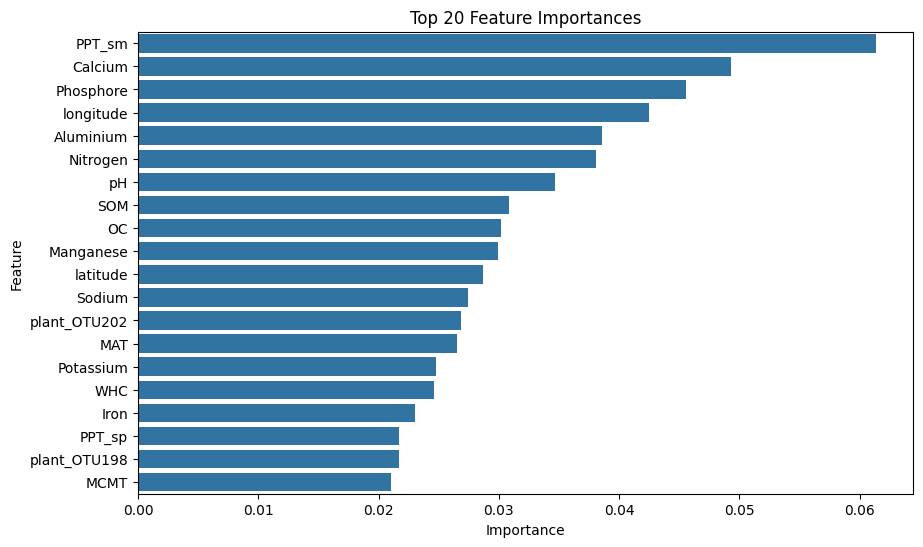


--- RMSE Assessment Original Microbiota Richness (Root) with Plant OTUs ---

RMSE (Train): 0.85853239470683
RMSE (Test): 1.0532175071288585
Standard Deviation of Test Target: 1.1169306729810924
RMSE < SD: Model is useful but has room for improvement.
Test RMSE > 1.15× Training RMSE: Model might be overfitting.
Selecting top 20 features: ['PPT_sm', 'Calcium', 'Phosphore', 'longitude', 'Aluminium', 'Nitrogen', 'pH', 'SOM', 'OC', 'Manganese', 'latitude', 'Sodium', 'plant_OTU202', 'MAT', 'Potassium', 'WHC', 'Iron', 'PPT_sp', 'plant_OTU198', 'MCMT']
Selecting top 20 features: ['PPT_sm', 'Calcium', 'Phosphore', 'longitude', 'Aluminium', 'Nitrogen', 'pH', 'SOM', 'OC', 'Manganese', 'latitude', 'Sodium', 'plant_OTU202', 'MAT', 'Potassium', 'WHC', 'Iron', 'PPT_sp', 'plant_OTU198', 'MCMT']

--- RMSE Assessment TOP-K Microbiota Richness (Root) with Plant OTUs ---

RMSE (Train): 0.8458517806331117
RMSE (Test): 1.0319479635681512
Standard Deviation of Test Target: 1.1169306729810924
RMSE < SD: Mode

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


Training data shape after imputation: (124, 67)
Test data shape after imputation: (32, 67)

--- Feature Importances ---

         Feature  Importance
7         PPT_sm    0.044125
1      longitude    0.042759
60  plant_OTU198    0.041385
0       latitude    0.034881
2      Elevation    0.034873
..           ...         ...
47  plant_OTU114    0.001156
59  plant_OTU196    0.000889
52  plant_OTU146    0.000824
39   plant_OTU72    0.000776
25    plant_OTU4    0.000736

[67 rows x 2 columns]


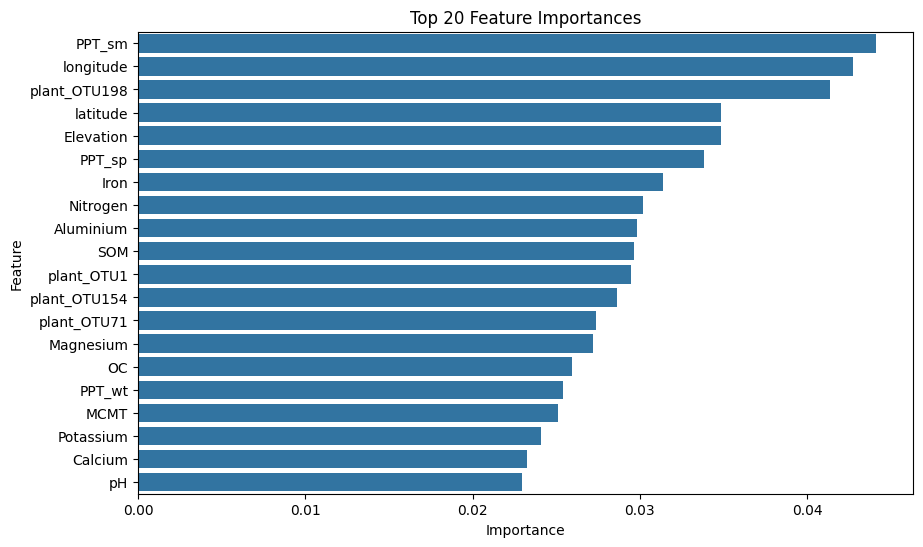


--- RMSE Assessment Original Microbiota Richness (Leaf) with Plant OTUs ---

RMSE (Train): 0.8069619940996285
RMSE (Test): 1.3901202984538992
Standard Deviation of Test Target: 1.3310274907757103
Test RMSE ≥ SD: Model performs no better than predicting the mean (R² ≤ 0).
Test RMSE > 1.15× Training RMSE: Model might be overfitting.
Selecting top 20 features: ['PPT_sm', 'longitude', 'plant_OTU198', 'latitude', 'Elevation', 'PPT_sp', 'Iron', 'Nitrogen', 'Aluminium', 'SOM', 'plant_OTU1', 'plant_OTU154', 'plant_OTU71', 'Magnesium', 'OC', 'PPT_wt', 'MCMT', 'Potassium', 'Calcium', 'pH']
Selecting top 20 features: ['PPT_sm', 'longitude', 'plant_OTU198', 'latitude', 'Elevation', 'PPT_sp', 'Iron', 'Nitrogen', 'Aluminium', 'SOM', 'plant_OTU1', 'plant_OTU154', 'plant_OTU71', 'Magnesium', 'OC', 'PPT_wt', 'MCMT', 'Potassium', 'Calcium', 'pH']

--- RMSE Assessment TOP-K Microbiota Richness (Leaf) with Plant OTUs ---

RMSE (Train): 0.78616431530109
RMSE (Test): 1.3957022437271418
Standard Deviation o

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(



--- Feature Importances ---

           Feature  Importance
7           PPT_sm    0.092012
12       Phosphore    0.073990
1        longitude    0.057255
11              pH    0.054343
18       Aluminium    0.054111
13         Calcium    0.050863
9         Nitrogen    0.046976
24   plant_Shannon    0.039321
0         latitude    0.038853
20              OC    0.038274
22       Manganese    0.038059
15          Sodium    0.036277
2        Elevation    0.034123
19             WHC    0.033924
21             SOM    0.032857
14       Magnesium    0.031484
10              CN    0.031245
16       Potassium    0.030998
3              MAT    0.028888
17            Iron    0.028685
8           PPT_at    0.027183
5           PPT_wt    0.026612
6           PPT_sp    0.026384
23  plant_richness    0.024391
4             MCMT    0.022893


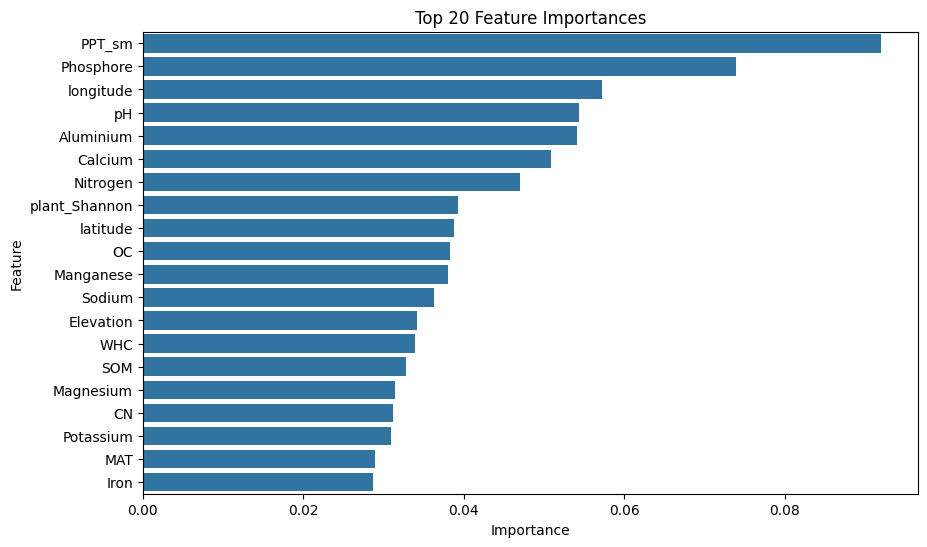


--- RMSE Assessment Original Microbiota Richness (Root) with Plant Metrics ---

RMSE (Train): 0.8196928937619982
RMSE (Test): 1.0701703189777023
Standard Deviation of Test Target: 1.1169306729810924
RMSE < SD: Model is useful but has room for improvement.
Test RMSE > 1.15× Training RMSE: Model might be overfitting.
Selecting top 20 features: ['PPT_sm', 'Phosphore', 'longitude', 'pH', 'Aluminium', 'Calcium', 'Nitrogen', 'plant_Shannon', 'latitude', 'OC', 'Manganese', 'Sodium', 'Elevation', 'WHC', 'SOM', 'Magnesium', 'CN', 'Potassium', 'MAT', 'Iron']
Selecting top 20 features: ['PPT_sm', 'Phosphore', 'longitude', 'pH', 'Aluminium', 'Calcium', 'Nitrogen', 'plant_Shannon', 'latitude', 'OC', 'Manganese', 'Sodium', 'Elevation', 'WHC', 'SOM', 'Magnesium', 'CN', 'Potassium', 'MAT', 'Iron']

--- RMSE Assessment TOP-K Microbiota Richness (Root) with Plant Metrics ---

RMSE (Train): 0.8369687302119614
RMSE (Test): 1.0794738260707435
Standard Deviation of Test Target: 1.1169306729810924
RMSE < SD

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(



--- Feature Importances ---

           Feature  Importance
24   plant_Shannon    0.082152
7           PPT_sm    0.059551
1        longitude    0.057269
23  plant_richness    0.049297
2        Elevation    0.048068
4             MCMT    0.045070
19             WHC    0.044464
6           PPT_sp    0.041446
17            Iron    0.041299
18       Aluminium    0.040811
13         Calcium    0.037752
8           PPT_at    0.036935
21             SOM    0.036472
20              OC    0.036349
16       Potassium    0.036322
9         Nitrogen    0.035895
14       Magnesium    0.035248
10              CN    0.034376
0         latitude    0.033145
11              pH    0.032813
3              MAT    0.031395
5           PPT_wt    0.030635
12       Phosphore    0.028156
15          Sodium    0.026577
22       Manganese    0.018500


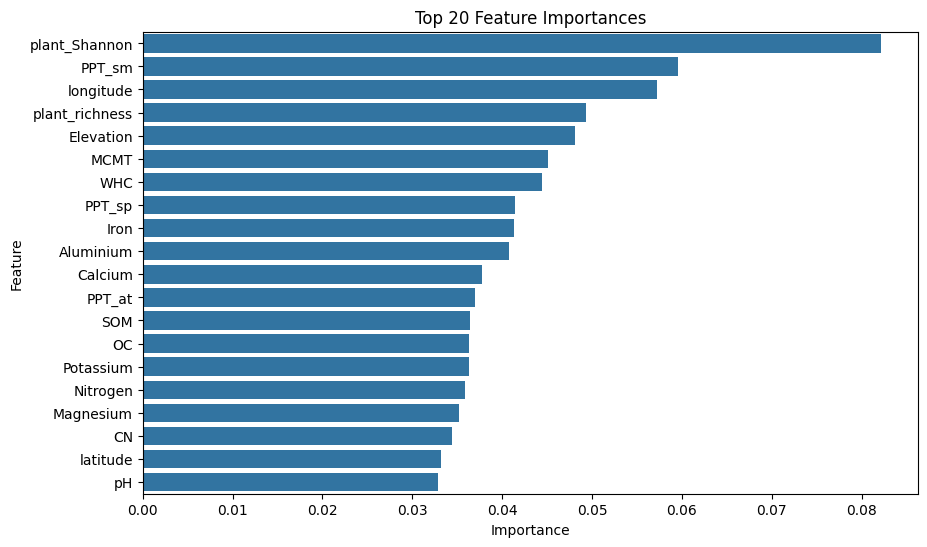


--- RMSE Assessment Original Microbiota Richness (Leaf) with Plant Metrics ---

RMSE (Train): 0.7869377579388531
RMSE (Test): 1.4200170798625333
Standard Deviation of Test Target: 1.3310274907757103
Test RMSE ≥ SD: Model performs no better than predicting the mean (R² ≤ 0).
Test RMSE > 1.15× Training RMSE: Model might be overfitting.
Selecting top 20 features: ['plant_Shannon', 'PPT_sm', 'longitude', 'plant_richness', 'Elevation', 'MCMT', 'WHC', 'PPT_sp', 'Iron', 'Aluminium', 'Calcium', 'PPT_at', 'SOM', 'OC', 'Potassium', 'Nitrogen', 'Magnesium', 'CN', 'latitude', 'pH']
Selecting top 20 features: ['plant_Shannon', 'PPT_sm', 'longitude', 'plant_richness', 'Elevation', 'MCMT', 'WHC', 'PPT_sp', 'Iron', 'Aluminium', 'Calcium', 'PPT_at', 'SOM', 'OC', 'Potassium', 'Nitrogen', 'Magnesium', 'CN', 'latitude', 'pH']

--- RMSE Assessment TOP-K Microbiota Richness (Leaf) with Plant Metrics ---

RMSE (Train): 0.7921305150941585
RMSE (Test): 1.4179181670357275
Standard Deviation of Test Target: 1.3

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(



--- Feature Importances ---

         Feature  Importance
1      longitude    0.058421
7         PPT_sm    0.040397
12     Phosphore    0.040207
2      Elevation    0.034252
0       latitude    0.033046
..           ...         ...
63  plant_OTU204    0.001029
52  plant_OTU146    0.000818
35   plant_OTU49    0.000731
47  plant_OTU114    0.000373
59  plant_OTU196    0.000230

[67 rows x 2 columns]


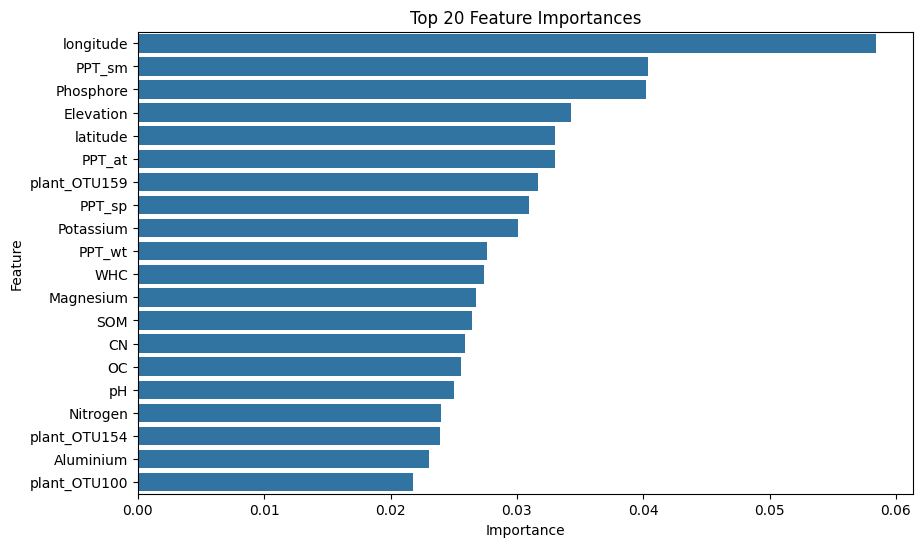


--- RMSE Assessment Original Microbiota Shannon (Root) with Plant OTUs ---

RMSE (Train): 0.1928945226927149
RMSE (Test): 0.2646396147626097
Standard Deviation of Test Target: 0.25314543385423727
Test RMSE ≥ SD: Model performs no better than predicting the mean (R² ≤ 0).
Test RMSE > 1.15× Training RMSE: Model might be overfitting.
Selecting top 20 features: ['longitude', 'PPT_sm', 'Phosphore', 'Elevation', 'latitude', 'PPT_at', 'plant_OTU159', 'PPT_sp', 'Potassium', 'PPT_wt', 'WHC', 'Magnesium', 'SOM', 'CN', 'OC', 'pH', 'Nitrogen', 'plant_OTU154', 'Aluminium', 'plant_OTU100']
Selecting top 20 features: ['longitude', 'PPT_sm', 'Phosphore', 'Elevation', 'latitude', 'PPT_at', 'plant_OTU159', 'PPT_sp', 'Potassium', 'PPT_wt', 'WHC', 'Magnesium', 'SOM', 'CN', 'OC', 'pH', 'Nitrogen', 'plant_OTU154', 'Aluminium', 'plant_OTU100']

--- RMSE Assessment TOP-K Microbiota Shannon (Root) with Plant OTUs ---

RMSE (Train): 0.1864650270202315
RMSE (Test): 0.269039748640115
Standard Deviation of Test T

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(



--- Feature Importances ---

         Feature  Importance
2      Elevation    0.059646
6         PPT_sp    0.053988
1      longitude    0.051125
0       latitude    0.035677
14     Magnesium    0.035537
..           ...         ...
35   plant_OTU49    0.001265
52  plant_OTU146    0.001255
39   plant_OTU72    0.001141
47  plant_OTU114    0.000704
59  plant_OTU196    0.000694

[67 rows x 2 columns]


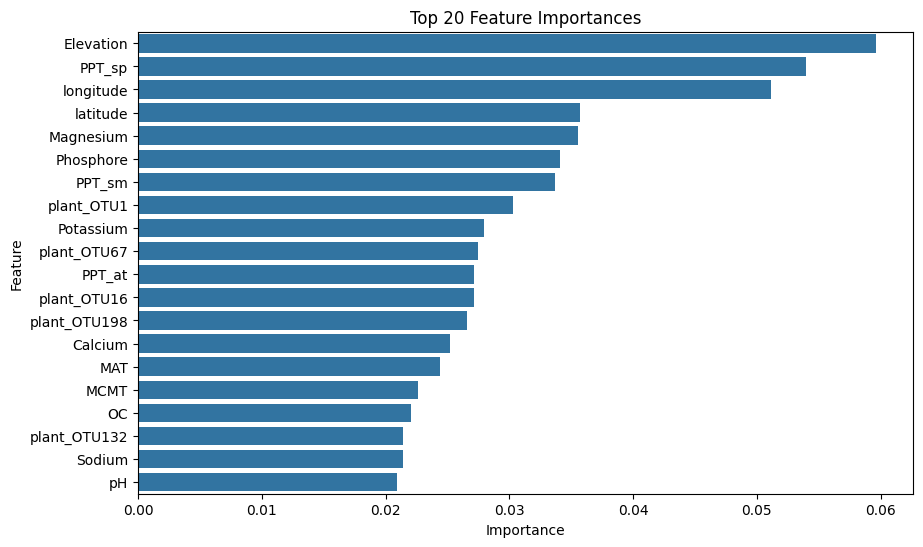


--- RMSE Assessment Original Microbiota Shannon (Leaf) with Plant OTUs ---

RMSE (Train): 0.14130953149259864
RMSE (Test): 0.2540652862406758
Standard Deviation of Test Target: 0.23708230774949685
Test RMSE ≥ SD: Model performs no better than predicting the mean (R² ≤ 0).
Test RMSE > 1.15× Training RMSE: Model might be overfitting.
Selecting top 20 features: ['Elevation', 'PPT_sp', 'longitude', 'latitude', 'Magnesium', 'Phosphore', 'PPT_sm', 'plant_OTU1', 'Potassium', 'plant_OTU67', 'PPT_at', 'plant_OTU16', 'plant_OTU198', 'Calcium', 'MAT', 'MCMT', 'OC', 'plant_OTU132', 'Sodium', 'pH']
Selecting top 20 features: ['Elevation', 'PPT_sp', 'longitude', 'latitude', 'Magnesium', 'Phosphore', 'PPT_sm', 'plant_OTU1', 'Potassium', 'plant_OTU67', 'PPT_at', 'plant_OTU16', 'plant_OTU198', 'Calcium', 'MAT', 'MCMT', 'OC', 'plant_OTU132', 'Sodium', 'pH']

--- RMSE Assessment TOP-K Microbiota Shannon (Leaf) with Plant OTUs ---

RMSE (Train): 0.138113993756639
RMSE (Test): 0.2512982671789332
Standard 

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(



--- Training Model for Microbiota Shannon (Root) with Plant Metrics ---
Training data scaled shape: (127, 25)
Test data scaled shape: (32, 25)
Training data shape after imputation: (127, 25)
Test data shape after imputation: (32, 25)

--- Feature Importances ---

           Feature  Importance
1        longitude    0.098869
12       Phosphore    0.069755
7           PPT_sm    0.068125
0         latitude    0.049821
8           PPT_at    0.048595
2        Elevation    0.046341
14       Magnesium    0.046019
6           PPT_sp    0.044499
16       Potassium    0.042331
19             WHC    0.041703
5           PPT_wt    0.035608
13         Calcium    0.035570
3              MAT    0.034694
11              pH    0.034676
21             SOM    0.032548
10              CN    0.032051
9         Nitrogen    0.030160
24   plant_Shannon    0.028726
15          Sodium    0.028649
20              OC    0.028134
18       Aluminium    0.027253
22       Manganese    0.027162
17            Iron    

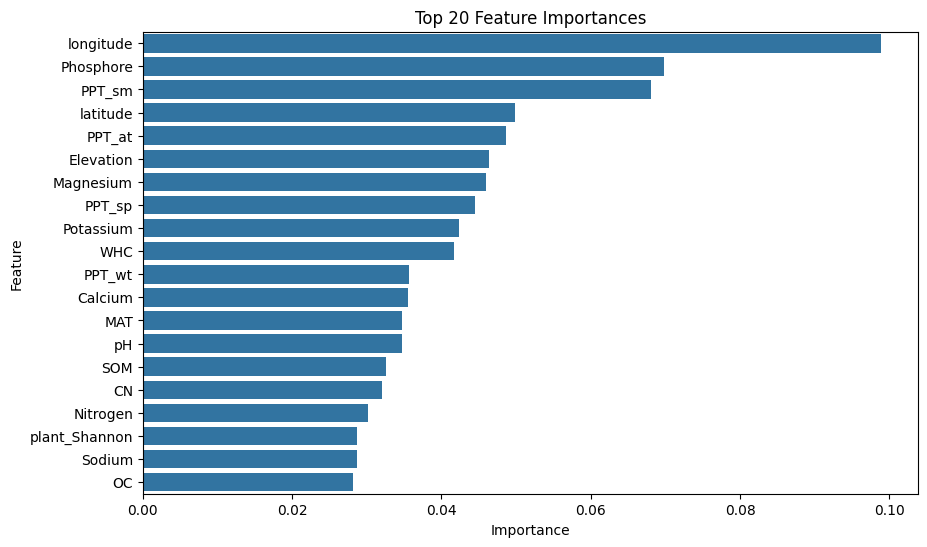


--- RMSE Assessment Original Microbiota Shannon (Root) with Plant Metrics ---

RMSE (Train): 0.1852639856019046
RMSE (Test): 0.2565708218287642
Standard Deviation of Test Target: 0.25314543385423727
Test RMSE ≥ SD: Model performs no better than predicting the mean (R² ≤ 0).
Test RMSE > 1.15× Training RMSE: Model might be overfitting.
Selecting top 20 features: ['longitude', 'Phosphore', 'PPT_sm', 'latitude', 'PPT_at', 'Elevation', 'Magnesium', 'PPT_sp', 'Potassium', 'WHC', 'PPT_wt', 'Calcium', 'MAT', 'pH', 'SOM', 'CN', 'Nitrogen', 'plant_Shannon', 'Sodium', 'OC']
Selecting top 20 features: ['longitude', 'Phosphore', 'PPT_sm', 'latitude', 'PPT_at', 'Elevation', 'Magnesium', 'PPT_sp', 'Potassium', 'WHC', 'PPT_wt', 'Calcium', 'MAT', 'pH', 'SOM', 'CN', 'Nitrogen', 'plant_Shannon', 'Sodium', 'OC']

--- RMSE Assessment TOP-K Microbiota Shannon (Root) with Plant Metrics ---

RMSE (Train): 0.18532216092521842
RMSE (Test): 0.256123875853751
Standard Deviation of Test Target: 0.2531454338542372

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(



--- Feature Importances ---

           Feature  Importance
2        Elevation    0.085081
6           PPT_sp    0.075043
24   plant_Shannon    0.069834
1        longitude    0.066484
7           PPT_sm    0.051056
14       Magnesium    0.048020
0         latitude    0.044650
23  plant_richness    0.043255
12       Phosphore    0.042140
16       Potassium    0.038478
13         Calcium    0.036475
4             MCMT    0.036080
3              MAT    0.035924
11              pH    0.034066
10              CN    0.032703
8           PPT_at    0.030509
19             WHC    0.029995
9         Nitrogen    0.028660
17            Iron    0.028136
15          Sodium    0.027230
20              OC    0.027107
18       Aluminium    0.026223
21             SOM    0.025623
5           PPT_wt    0.021221
22       Manganese    0.016006


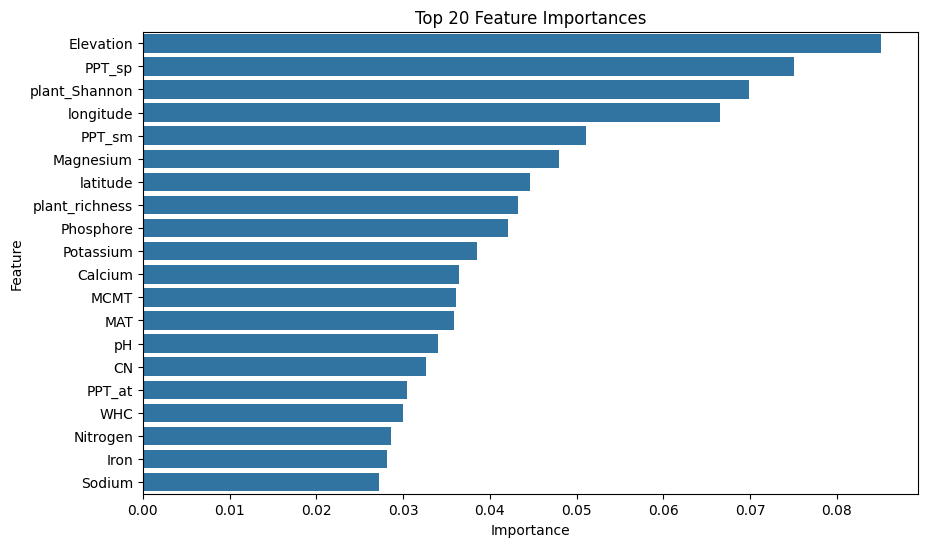


--- RMSE Assessment Original Microbiota Shannon (Leaf) with Plant Metrics ---

RMSE (Train): 0.13567725530447486
RMSE (Test): 0.25390830567857364
Standard Deviation of Test Target: 0.23708230774949685
Test RMSE ≥ SD: Model performs no better than predicting the mean (R² ≤ 0).
Test RMSE > 1.15× Training RMSE: Model might be overfitting.
Selecting top 20 features: ['Elevation', 'PPT_sp', 'plant_Shannon', 'longitude', 'PPT_sm', 'Magnesium', 'latitude', 'plant_richness', 'Phosphore', 'Potassium', 'Calcium', 'MCMT', 'MAT', 'pH', 'CN', 'PPT_at', 'WHC', 'Nitrogen', 'Iron', 'Sodium']
Selecting top 20 features: ['Elevation', 'PPT_sp', 'plant_Shannon', 'longitude', 'PPT_sm', 'Magnesium', 'latitude', 'plant_richness', 'Phosphore', 'Potassium', 'Calcium', 'MCMT', 'MAT', 'pH', 'CN', 'PPT_at', 'WHC', 'Nitrogen', 'Iron', 'Sodium']

--- RMSE Assessment TOP-K Microbiota Shannon (Leaf) with Plant Metrics ---

RMSE (Train): 0.13784228577533864
RMSE (Test): 0.2541167481209187
Standard Deviation of Test T

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(



--- Feature Importances ---

         Feature  Importance
7         PPT_sm    0.050910
0       latitude    0.044512
9       Nitrogen    0.039867
42   plant_OTU87    0.039822
14     Magnesium    0.038349
..           ...         ...
56  plant_OTU159    0.000806
63  plant_OTU204    0.000612
52  plant_OTU146    0.000402
28   plant_OTU10    0.000182
25    plant_OTU4    0.000000

[67 rows x 2 columns]


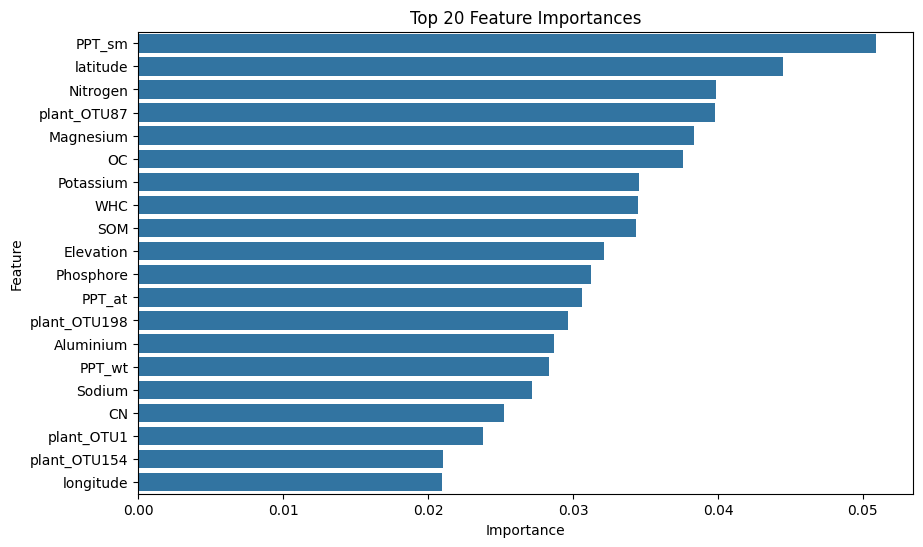


--- RMSE Assessment Original Pathobiota Richness (Root) with Plant OTUs ---

RMSE (Train): 0.12286245364642545
RMSE (Test): 0.23117532776484084
Standard Deviation of Test Target: 0.22759919092467426
Test RMSE ≥ SD: Model performs no better than predicting the mean (R² ≤ 0).
Test RMSE > 1.15× Training RMSE: Model might be overfitting.
Selecting top 20 features: ['PPT_sm', 'latitude', 'Nitrogen', 'plant_OTU87', 'Magnesium', 'OC', 'Potassium', 'WHC', 'SOM', 'Elevation', 'Phosphore', 'PPT_at', 'plant_OTU198', 'Aluminium', 'PPT_wt', 'Sodium', 'CN', 'plant_OTU1', 'plant_OTU154', 'longitude']
Selecting top 20 features: ['PPT_sm', 'latitude', 'Nitrogen', 'plant_OTU87', 'Magnesium', 'OC', 'Potassium', 'WHC', 'SOM', 'Elevation', 'Phosphore', 'PPT_at', 'plant_OTU198', 'Aluminium', 'PPT_wt', 'Sodium', 'CN', 'plant_OTU1', 'plant_OTU154', 'longitude']

--- RMSE Assessment TOP-K Pathobiota Richness (Root) with Plant OTUs ---

RMSE (Train): 0.12218418318116984
RMSE (Test): 0.23618301447007164
Standar

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(



--- Feature Importances ---

         Feature  Importance
0       latitude    0.040927
1      longitude    0.040596
4           MCMT    0.039030
31   plant_OTU18    0.037586
19           WHC    0.037124
..           ...         ...
47  plant_OTU114    0.001479
25    plant_OTU4    0.000784
52  plant_OTU146    0.000655
39   plant_OTU72    0.000529
49  plant_OTU136    0.000458

[67 rows x 2 columns]


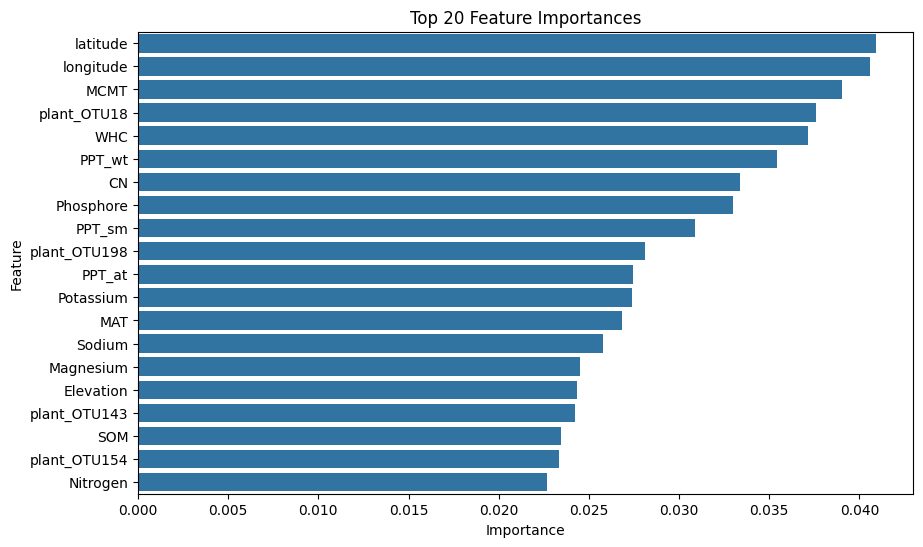


--- RMSE Assessment Original Pathobiota Richness (Leaf) with Plant OTUs ---

RMSE (Train): 0.32654008323541434
RMSE (Test): 0.4679635508544991
Standard Deviation of Test Target: 0.49356700021006056
RMSE < SD: Model is useful but has room for improvement.
Test RMSE > 1.15× Training RMSE: Model might be overfitting.
Selecting top 20 features: ['latitude', 'longitude', 'MCMT', 'plant_OTU18', 'WHC', 'PPT_wt', 'CN', 'Phosphore', 'PPT_sm', 'plant_OTU198', 'PPT_at', 'Potassium', 'MAT', 'Sodium', 'Magnesium', 'Elevation', 'plant_OTU143', 'SOM', 'plant_OTU154', 'Nitrogen']
Selecting top 20 features: ['latitude', 'longitude', 'MCMT', 'plant_OTU18', 'WHC', 'PPT_wt', 'CN', 'Phosphore', 'PPT_sm', 'plant_OTU198', 'PPT_at', 'Potassium', 'MAT', 'Sodium', 'Magnesium', 'Elevation', 'plant_OTU143', 'SOM', 'plant_OTU154', 'Nitrogen']

--- RMSE Assessment TOP-K Pathobiota Richness (Leaf) with Plant OTUs ---

RMSE (Train): 0.3239383633048549
RMSE (Test): 0.46726727399748175
Standard Deviation of Test Targe

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(



--- Feature Importances ---

           Feature  Importance
7           PPT_sm    0.083985
0         latitude    0.062510
19             WHC    0.056895
9         Nitrogen    0.056600
20              OC    0.051105
16       Potassium    0.048512
14       Magnesium    0.046195
12       Phosphore    0.044445
21             SOM    0.042704
18       Aluminium    0.041973
2        Elevation    0.039593
24   plant_Shannon    0.039110
15          Sodium    0.037881
10              CN    0.037686
8           PPT_at    0.037164
11              pH    0.037068
5           PPT_wt    0.034037
13         Calcium    0.029774
23  plant_richness    0.029311
4             MCMT    0.029243
3              MAT    0.028472
1        longitude    0.026623
6           PPT_sp    0.025358
17            Iron    0.020998
22       Manganese    0.012758


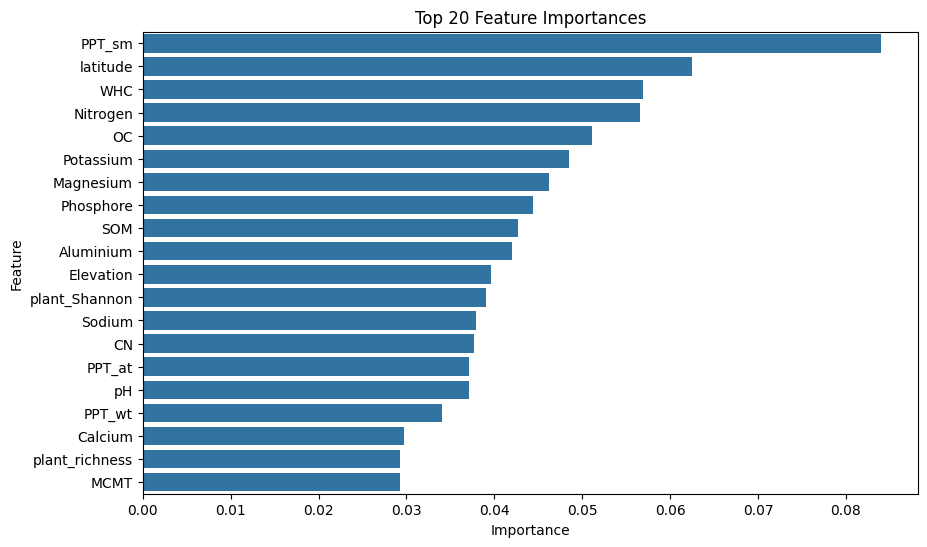


--- RMSE Assessment Original Pathobiota Richness (Root) with Plant Metrics ---

RMSE (Train): 0.11850555153566085
RMSE (Test): 0.23493295160377628
Standard Deviation of Test Target: 0.22759919092467426
Test RMSE ≥ SD: Model performs no better than predicting the mean (R² ≤ 0).
Test RMSE > 1.15× Training RMSE: Model might be overfitting.
Selecting top 20 features: ['PPT_sm', 'latitude', 'WHC', 'Nitrogen', 'OC', 'Potassium', 'Magnesium', 'Phosphore', 'SOM', 'Aluminium', 'Elevation', 'plant_Shannon', 'Sodium', 'CN', 'PPT_at', 'pH', 'PPT_wt', 'Calcium', 'plant_richness', 'MCMT']
Selecting top 20 features: ['PPT_sm', 'latitude', 'WHC', 'Nitrogen', 'OC', 'Potassium', 'Magnesium', 'Phosphore', 'SOM', 'Aluminium', 'Elevation', 'plant_Shannon', 'Sodium', 'CN', 'PPT_at', 'pH', 'PPT_wt', 'Calcium', 'plant_richness', 'MCMT']

--- RMSE Assessment TOP-K Pathobiota Richness (Root) with Plant Metrics ---

RMSE (Train): 0.12058996855912625
RMSE (Test): 0.23616484582728844
Standard Deviation of Test Ta

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(



--- Feature Importances ---

           Feature  Importance
4             MCMT    0.060893
1        longitude    0.057479
19             WHC    0.057270
10              CN    0.056226
0         latitude    0.054915
8           PPT_at    0.053298
12       Phosphore    0.051637
16       Potassium    0.051106
5           PPT_wt    0.049057
7           PPT_sm    0.045325
15          Sodium    0.039629
14       Magnesium    0.038858
24   plant_Shannon    0.034863
20              OC    0.034836
9         Nitrogen    0.034337
11              pH    0.031702
18       Aluminium    0.031448
3              MAT    0.031193
21             SOM    0.029737
23  plant_richness    0.029711
17            Iron    0.028380
2        Elevation    0.027821
6           PPT_sp    0.026854
13         Calcium    0.026107
22       Manganese    0.017317


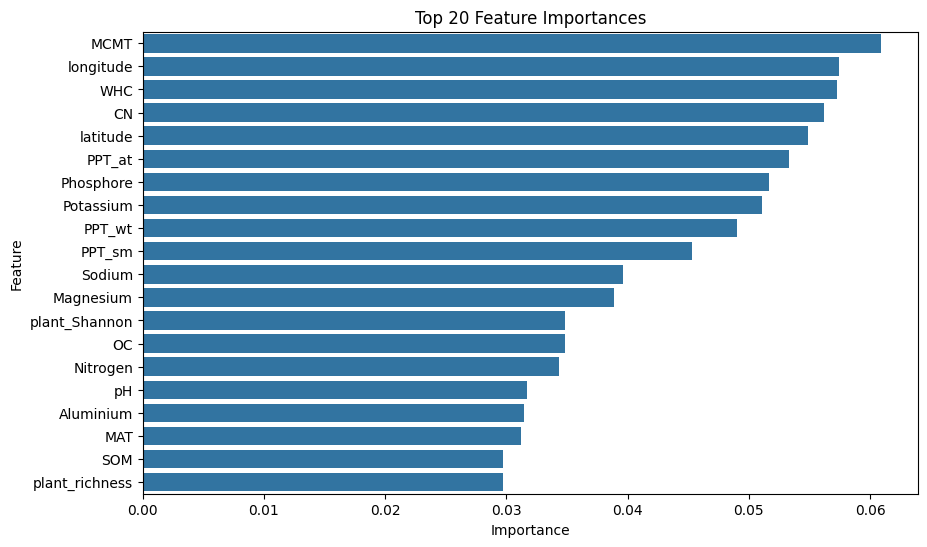


--- RMSE Assessment Original Pathobiota Richness (Leaf) with Plant Metrics ---

RMSE (Train): 0.31941993449962236
RMSE (Test): 0.46917692037456005
Standard Deviation of Test Target: 0.49356700021006056
RMSE < SD: Model is useful but has room for improvement.
Test RMSE > 1.15× Training RMSE: Model might be overfitting.
Selecting top 20 features: ['MCMT', 'longitude', 'WHC', 'CN', 'latitude', 'PPT_at', 'Phosphore', 'Potassium', 'PPT_wt', 'PPT_sm', 'Sodium', 'Magnesium', 'plant_Shannon', 'OC', 'Nitrogen', 'pH', 'Aluminium', 'MAT', 'SOM', 'plant_richness']
Selecting top 20 features: ['MCMT', 'longitude', 'WHC', 'CN', 'latitude', 'PPT_at', 'Phosphore', 'Potassium', 'PPT_wt', 'PPT_sm', 'Sodium', 'Magnesium', 'plant_Shannon', 'OC', 'Nitrogen', 'pH', 'Aluminium', 'MAT', 'SOM', 'plant_richness']

--- RMSE Assessment TOP-K Pathobiota Richness (Leaf) with Plant Metrics ---

RMSE (Train): 0.32498684835248093
RMSE (Test): 0.4633227804810935
Standard Deviation of Test Target: 0.49356700021006056
RM

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(



--- Feature Importances ---

         Feature  Importance
7         PPT_sm    0.053041
0       latitude    0.034552
64  plant_OTU216    0.034428
9       Nitrogen    0.033563
2      Elevation    0.031730
..           ...         ...
28   plant_OTU10    0.000740
63  plant_OTU204    0.000697
39   plant_OTU72    0.000689
43   plant_OTU88    0.000603
52  plant_OTU146    0.000269

[67 rows x 2 columns]


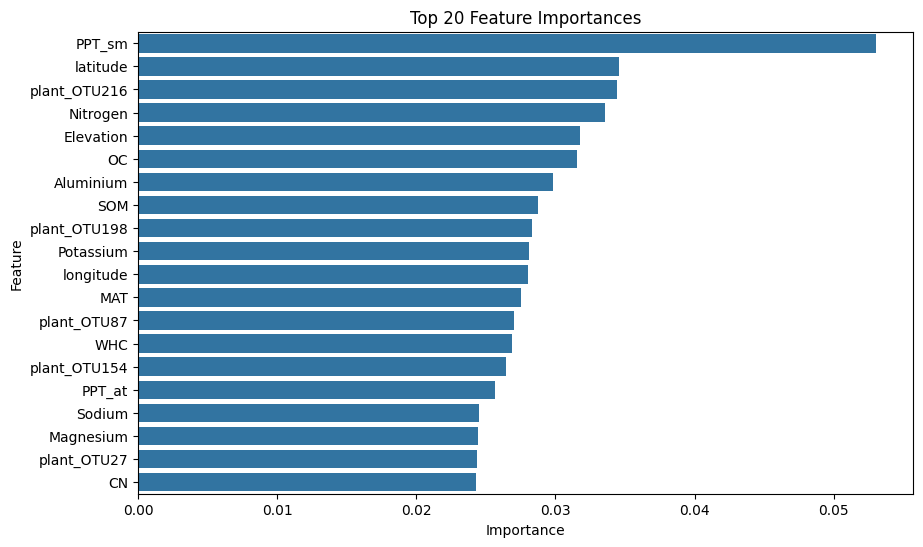


--- RMSE Assessment Original Pathobiota Shannon (Root) with Plant OTUs ---

RMSE (Train): 0.06403350051472184
RMSE (Test): 0.1139028832073553
Standard Deviation of Test Target: 0.11494978312690925
RMSE < SD: Model is useful but has room for improvement.
Test RMSE > 1.15× Training RMSE: Model might be overfitting.
Selecting top 20 features: ['PPT_sm', 'latitude', 'plant_OTU216', 'Nitrogen', 'Elevation', 'OC', 'Aluminium', 'SOM', 'plant_OTU198', 'Potassium', 'longitude', 'MAT', 'plant_OTU87', 'WHC', 'plant_OTU154', 'PPT_at', 'Sodium', 'Magnesium', 'plant_OTU27', 'CN']
Selecting top 20 features: ['PPT_sm', 'latitude', 'plant_OTU216', 'Nitrogen', 'Elevation', 'OC', 'Aluminium', 'SOM', 'plant_OTU198', 'Potassium', 'longitude', 'MAT', 'plant_OTU87', 'WHC', 'plant_OTU154', 'PPT_at', 'Sodium', 'Magnesium', 'plant_OTU27', 'CN']

--- RMSE Assessment TOP-K Pathobiota Shannon (Root) with Plant OTUs ---

RMSE (Train): 0.06306918647830771
RMSE (Test): 0.1197368820803068
Standard Deviation of Test T

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(



--- Feature Importances ---

         Feature  Importance
7         PPT_sm    0.058138
1      longitude    0.040307
3            MAT    0.039960
12     Phosphore    0.033738
2      Elevation    0.033414
..           ...         ...
24    plant_OTU3    0.001461
63  plant_OTU204    0.000757
39   plant_OTU72    0.000727
25    plant_OTU4    0.000607
52  plant_OTU146    0.000331

[67 rows x 2 columns]


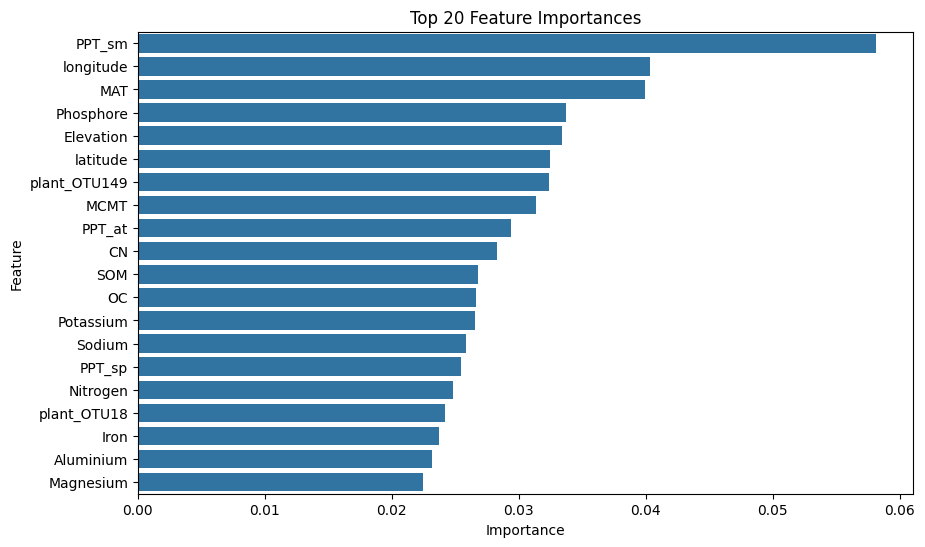


--- RMSE Assessment Original Pathobiota Shannon (Leaf) with Plant OTUs ---

RMSE (Train): 0.0856855841938164
RMSE (Test): 0.12074378794148533
Standard Deviation of Test Target: 0.11296695534417847
Test RMSE ≥ SD: Model performs no better than predicting the mean (R² ≤ 0).
Test RMSE > 1.15× Training RMSE: Model might be overfitting.
Selecting top 20 features: ['PPT_sm', 'longitude', 'MAT', 'Phosphore', 'Elevation', 'latitude', 'plant_OTU149', 'MCMT', 'PPT_at', 'CN', 'SOM', 'OC', 'Potassium', 'Sodium', 'PPT_sp', 'Nitrogen', 'plant_OTU18', 'Iron', 'Aluminium', 'Magnesium']
Selecting top 20 features: ['PPT_sm', 'longitude', 'MAT', 'Phosphore', 'Elevation', 'latitude', 'plant_OTU149', 'MCMT', 'PPT_at', 'CN', 'SOM', 'OC', 'Potassium', 'Sodium', 'PPT_sp', 'Nitrogen', 'plant_OTU18', 'Iron', 'Aluminium', 'Magnesium']

--- RMSE Assessment TOP-K Pathobiota Shannon (Leaf) with Plant OTUs ---

RMSE (Train): 0.08342928867057035
RMSE (Test): 0.12091486628145204
Standard Deviation of Test Target: 0.1

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(



--- Feature Importances ---

           Feature  Importance
7           PPT_sm    0.095700
0         latitude    0.056830
20              OC    0.055874
9         Nitrogen    0.054161
2        Elevation    0.045004
14       Magnesium    0.044750
8           PPT_at    0.044632
1        longitude    0.044178
16       Potassium    0.044158
19             WHC    0.043640
18       Aluminium    0.043284
24   plant_Shannon    0.042705
21             SOM    0.042579
6           PPT_sp    0.040899
3              MAT    0.035523
12       Phosphore    0.034957
10              CN    0.034602
15          Sodium    0.033085
11              pH    0.028359
4             MCMT    0.027427
13         Calcium    0.026529
5           PPT_wt    0.024231
17            Iron    0.023742
23  plant_richness    0.020156
22       Manganese    0.012996


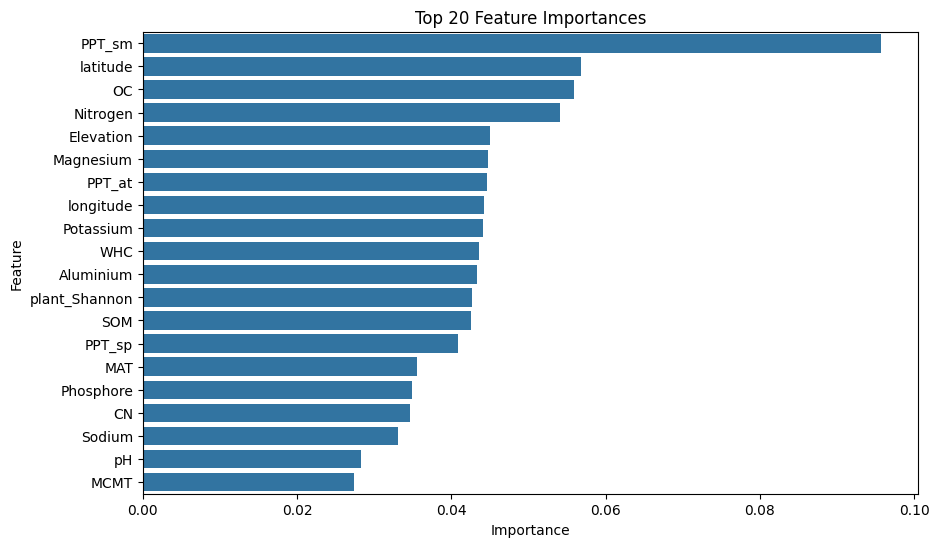


--- RMSE Assessment Original Pathobiota Shannon (Root) with Plant Metrics ---

RMSE (Train): 0.06283040911901919
RMSE (Test): 0.11624184066394047
Standard Deviation of Test Target: 0.11494978312690925
Test RMSE ≥ SD: Model performs no better than predicting the mean (R² ≤ 0).
Test RMSE > 1.15× Training RMSE: Model might be overfitting.
Selecting top 20 features: ['PPT_sm', 'latitude', 'OC', 'Nitrogen', 'Elevation', 'Magnesium', 'PPT_at', 'longitude', 'Potassium', 'WHC', 'Aluminium', 'plant_Shannon', 'SOM', 'PPT_sp', 'MAT', 'Phosphore', 'CN', 'Sodium', 'pH', 'MCMT']
Selecting top 20 features: ['PPT_sm', 'latitude', 'OC', 'Nitrogen', 'Elevation', 'Magnesium', 'PPT_at', 'longitude', 'Potassium', 'WHC', 'Aluminium', 'plant_Shannon', 'SOM', 'PPT_sp', 'MAT', 'Phosphore', 'CN', 'Sodium', 'pH', 'MCMT']

--- RMSE Assessment TOP-K Pathobiota Shannon (Root) with Plant Metrics ---

RMSE (Train): 0.06326984853843967
RMSE (Test): 0.11809073489011787
Standard Deviation of Test Target: 0.114949783126

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(



--- Feature Importances ---

           Feature  Importance
7           PPT_sm    0.080464
1        longitude    0.070710
8           PPT_at    0.057916
3              MAT    0.050187
0         latitude    0.045880
10              CN    0.044838
4             MCMT    0.044561
12       Phosphore    0.042963
2        Elevation    0.041015
6           PPT_sp    0.039826
21             SOM    0.039491
16       Potassium    0.038182
15          Sodium    0.036568
5           PPT_wt    0.035113
13         Calcium    0.034696
18       Aluminium    0.034607
20              OC    0.034282
11              pH    0.033655
14       Magnesium    0.032684
9         Nitrogen    0.031454
24   plant_Shannon    0.031279
17            Iron    0.030847
19             WHC    0.028861
23  plant_richness    0.026782
22       Manganese    0.013139


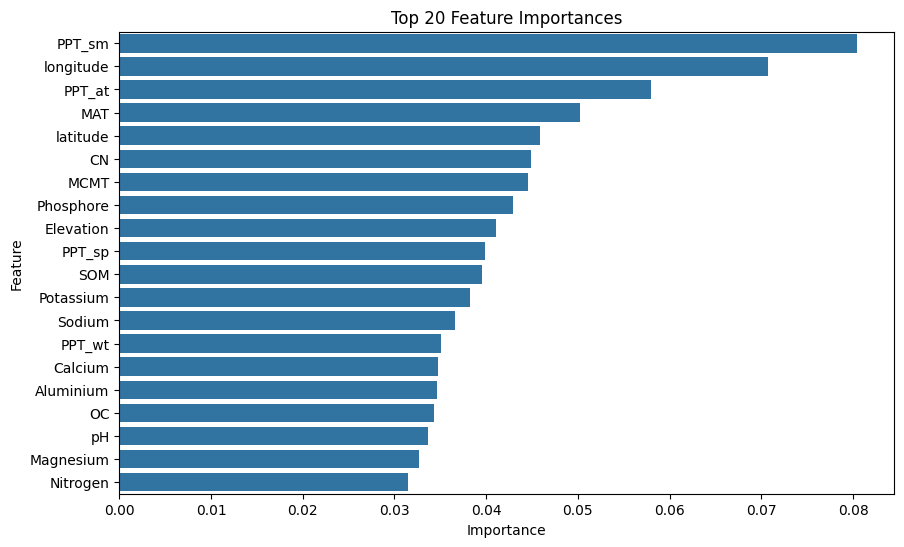


--- RMSE Assessment Original Pathobiota Shannon (Leaf) with Plant Metrics ---

RMSE (Train): 0.08198815775232099
RMSE (Test): 0.122546203482765
Standard Deviation of Test Target: 0.11296695534417847
Test RMSE ≥ SD: Model performs no better than predicting the mean (R² ≤ 0).
Test RMSE > 1.15× Training RMSE: Model might be overfitting.
Selecting top 20 features: ['PPT_sm', 'longitude', 'PPT_at', 'MAT', 'latitude', 'CN', 'MCMT', 'Phosphore', 'Elevation', 'PPT_sp', 'SOM', 'Potassium', 'Sodium', 'PPT_wt', 'Calcium', 'Aluminium', 'OC', 'pH', 'Magnesium', 'Nitrogen']
Selecting top 20 features: ['PPT_sm', 'longitude', 'PPT_at', 'MAT', 'latitude', 'CN', 'MCMT', 'Phosphore', 'Elevation', 'PPT_sp', 'SOM', 'Potassium', 'Sodium', 'PPT_wt', 'Calcium', 'Aluminium', 'OC', 'pH', 'Magnesium', 'Nitrogen']

--- RMSE Assessment TOP-K Pathobiota Shannon (Leaf) with Plant Metrics ---

RMSE (Train): 0.08419366690987311
RMSE (Test): 0.1231091919476201
Standard Deviation of Test Target: 0.11296695534417847
Tes

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


{'Microbiota Richness (Root) with Plant OTUs': {'R2 (Train)': 0.669784220549703,
  'R2 (Test)': 0.11083224722490681,
  'OOB Score': 0.015165449184090685,
  'RMSE (Train)': 0.85853239470683,
  'RMSE (Test)': 1.0532175071288585,
  'Correlation': 0.3534192679231777,
  'Top-k R2 (Train)': 0.679466825812945,
  'Top-k R2 (Test)': 0.14638279194036774,
  'Top-k OOB Score': 0.04165761209112362,
  'Top-k RMSE (Train)': 0.8458517806331117,
  'Top-k RMSE (Test)': 1.0319479635681512,
  'Standard Deviation Y test': 1.1169306729810924,
  'Linear RMSE (Train)': 1.1652768089805232,
  'Linear RMSE (Test)': 1.6687519458600504},
 'Microbiota Richness (Leaf) with Plant OTUs': {'R2 (Train)': 0.6628461115920643,
  'R2 (Test)': -0.09076380704276965,
  'OOB Score': -0.041566078624442504,
  'RMSE (Train)': 0.8069619940996285,
  'RMSE (Test)': 1.3901202984538992,
  'Correlation': -0.09932166497696017,
  'Top-k R2 (Train)': 0.680000967997203,
  'Top-k R2 (Test)': -0.09954118847762183,
  'Top-k OOB Score': 0.01791

In [ ]:

# I have several machine learning models i want to build and compare the performances

# Model microbiota richness in root and shoot using environmental vars + (plant otus or [plant richness and shannon])

# Model microbiota shannon in root and shoot using environmental vars + (plant otus or [plant richness and shannon])

# Model pathobiota richness using environmental vars + (plant otus or [plant richness and shannon]) + OTUs that are not pahogens/OTUs that are not used to compute the pathobiota

# Model pathobiota shannon using + (plant otus or plant richness and [plant richness and shannon]) + OTUs that are not pahogens/OTUs that are not used to compute the pathobiota



tasks = {
    # Microbiota Richness
    "Microbiota Richness (Root) with Plant OTUs": {
        "target": "richness_microbiota_root",
        "features": framework.feature_categories['environmental'] + framework.feature_categories['plant_otus']
    },
    "Microbiota Richness (Leaf) with Plant OTUs": {
        "target": "richness_microbiota_leaf",
        "features": framework.feature_categories['environmental'] + framework.feature_categories['plant_otus']
    },
    "Microbiota Richness (Root) with Plant Metrics": {
        "target": "richness_microbiota_root",
        "features": framework.feature_categories['environmental'] + framework.feature_categories['plant_metrics']
    },
    "Microbiota Richness (Leaf) with Plant Metrics": {
        "target": "richness_microbiota_leaf",
        "features": framework.feature_categories['environmental'] + framework.feature_categories['plant_metrics']
    },

    # Microbiota Shannon Diversity
    "Microbiota Shannon (Root) with Plant OTUs": {
        "target": "Shannon_microbiota_root",
        "features": framework.feature_categories['environmental'] + framework.feature_categories['plant_otus']
    },
    "Microbiota Shannon (Leaf) with Plant OTUs": {
        "target": "Shannon_microbiota_leaf",
        "features": framework.feature_categories['environmental'] + framework.feature_categories['plant_otus']
    },
    "Microbiota Shannon (Root) with Plant Metrics": {
        "target": "Shannon_microbiota_root",
        "features": framework.feature_categories['environmental'] + framework.feature_categories['plant_metrics']
    },
    "Microbiota Shannon (Leaf) with Plant Metrics": {
        "target": "Shannon_microbiota_leaf",
        "features": framework.feature_categories['environmental'] + framework.feature_categories['plant_metrics']
    },

    # Pathobiota Richness
    "Pathobiota Richness (Root) with Plant OTUs": {
        "target": "richness_pathobiota_root",
        "features": framework.feature_categories['environmental'] + framework.feature_categories['plant_otus']
    },
    "Pathobiota Richness (Leaf) with Plant OTUs": {
        "target": "richness_pathobiota_leaf",
        "features": framework.feature_categories['environmental'] + framework.feature_categories['plant_otus']
    },
    "Pathobiota Richness (Root) with Plant Metrics": {
        "target": "richness_pathobiota_root",
        "features": framework.feature_categories['environmental'] + framework.feature_categories['plant_metrics']
    },
    "Pathobiota Richness (Leaf) with Plant Metrics": {
        "target": "richness_pathobiota_leaf",
        "features": framework.feature_categories['environmental'] + framework.feature_categories['plant_metrics']
    },

    # Pathobiota Shannon Diversity
    "Pathobiota Shannon (Root) with Plant OTUs": {
        "target": "Shannon_pathobiota_root",
        "features": framework.feature_categories['environmental'] + framework.feature_categories['plant_otus']
    },
    "Pathobiota Shannon (Leaf) with Plant OTUs": {
        "target": "Shannon_pathobiota_leaf",
        "features": framework.feature_categories['environmental'] + framework.feature_categories['plant_otus']
    },
    "Pathobiota Shannon (Root) with Plant Metrics": {
        "target": "Shannon_pathobiota_root",
        "features": framework.feature_categories['environmental'] + framework.feature_categories['plant_metrics']
    },
    "Pathobiota Shannon (Leaf) with Plant Metrics": {
        "target": "Shannon_pathobiota_leaf",
        "features": framework.feature_categories['environmental'] + framework.feature_categories['plant_metrics']
    }
}

#framework.check_data_quality(tasks)

framework.train_multiple_models(tasks)



# # framework.show_missing_values()
# # framework.export_data_to_excel("./ecological_parsed.xls")
# # framework.data.head()

# # framework.visualize_data()

# # framework.select_target_and_features(target_column='plant_richness', feature_categories=['environmental', 'leaf_otus'])
# # model = framework.train_model(missing_strategy='drop')
# # concatenated_data = framework.concatenate_features(['environmental', 'specific_metrics', 'plant_metrics'])
# # print("Concatenated Data Shape:", concatenated_data.shape)




Mounted at /content/drive

=== LOFO & Correlation Plot for Microbiota Richness (Root) with Plant OTUs ===
Training data scaled shape: (127, 67)
Test data scaled shape: (32, 67)
Training data shape after imputation: (127, 67)
Test data shape after imputation: (32, 67)

--- Feature Importances ---

         Feature  Importance
7         PPT_sm    0.061362
13       Calcium    0.049307
12     Phosphore    0.045537
1      longitude    0.042512
18     Aluminium    0.038597
..           ...         ...
49  plant_OTU136    0.000772
40   plant_OTU78    0.000594
66  plant_OTU234    0.000557
59  plant_OTU196    0.000543
47  plant_OTU114    0.000307

[67 rows x 2 columns]


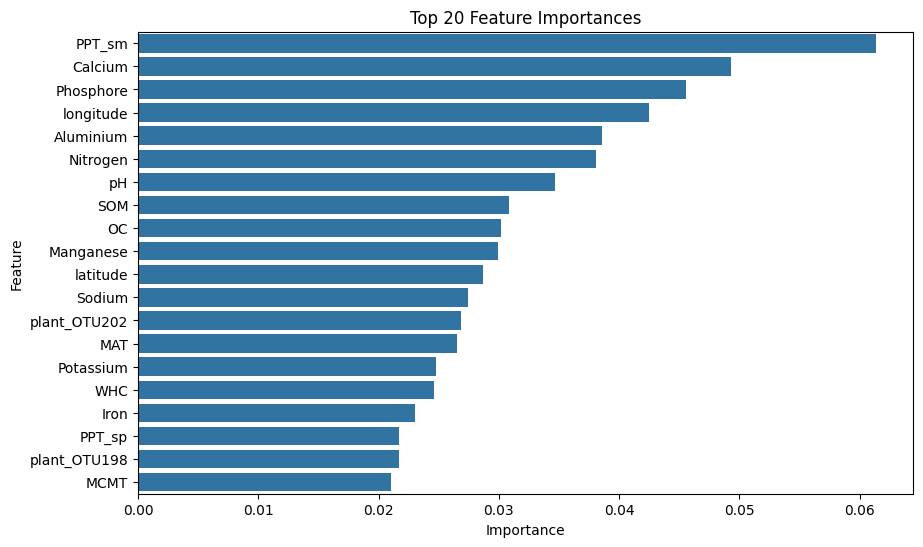

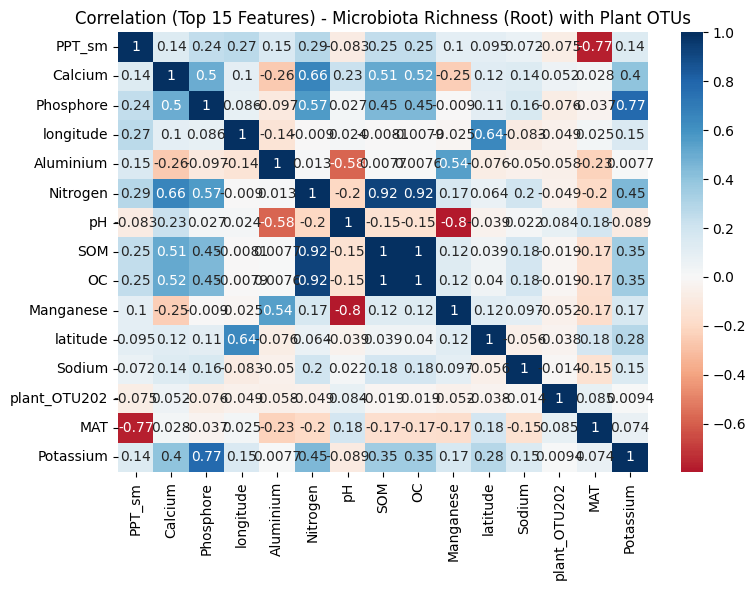


Dropping feature 'PPT_sm' => measuring test performance difference...
   => Original R2: 0.111, Dropped R2: 0.099, ΔR² = 0.011
   => Original RMSE: 1.053, Dropped RMSE: 1.060, ΔRMSE = 0.007
   => Repeated-CV: mean R2 diff = 0.054, p-value = 4.261e-07

Dropping feature 'Calcium' => measuring test performance difference...
   => Original R2: 0.111, Dropped R2: 0.112, ΔR² = -0.001
   => Original RMSE: 1.053, Dropped RMSE: 1.053, ΔRMSE = -0.001
   => Repeated-CV: mean R2 diff = 0.013, p-value = 0.1222

Dropping feature 'Phosphore' => measuring test performance difference...
   => Original R2: 0.111, Dropped R2: 0.113, ΔR² = -0.002
   => Original RMSE: 1.053, Dropped RMSE: 1.052, ΔRMSE = -0.001
   => Repeated-CV: mean R2 diff = 0.015, p-value = 0.071

Dropping feature 'longitude' => measuring test performance difference...
   => Original R2: 0.111, Dropped R2: 0.063, ΔR² = 0.048
   => Original RMSE: 1.053, Dropped RMSE: 1.081, ΔRMSE = 0.028
   => Repeated-CV: mean R2 diff = 0.013, p-value 

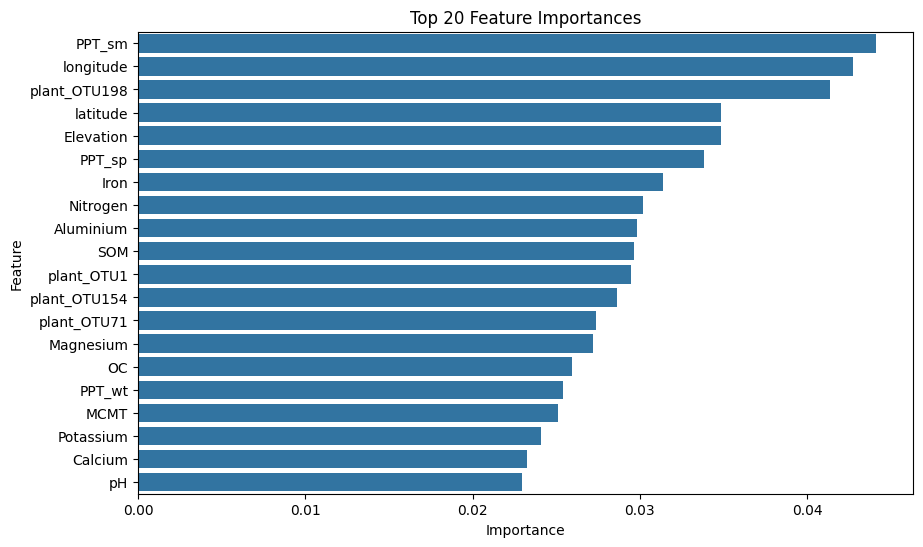

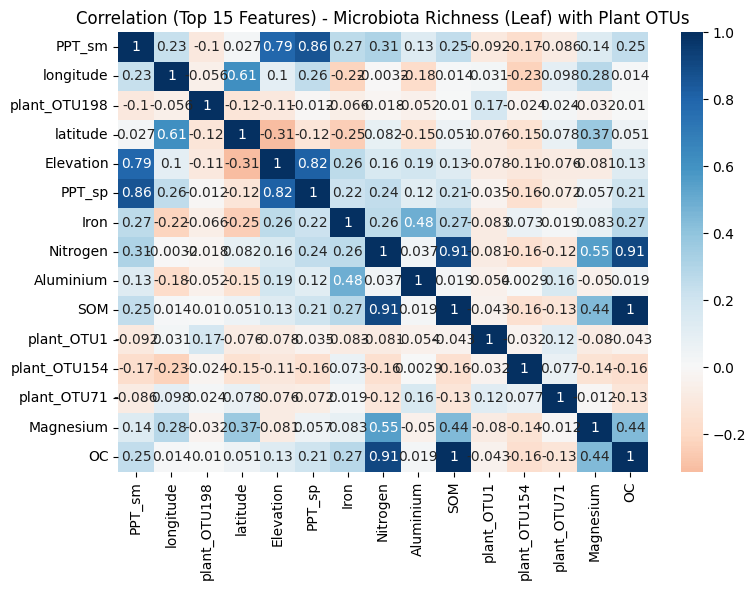


Dropping feature 'PPT_sm' => measuring test performance difference...
   => Original R2: -0.091, Dropped R2: -0.070, ΔR² = -0.021
   => Original RMSE: 1.390, Dropped RMSE: 1.377, ΔRMSE = -0.014
   => Repeated-CV: mean R2 diff = 0.015, p-value = 0.06089

Dropping feature 'longitude' => measuring test performance difference...
   => Original R2: -0.091, Dropped R2: -0.099, ΔR² = 0.008
   => Original RMSE: 1.390, Dropped RMSE: 1.395, ΔRMSE = 0.005
   => Repeated-CV: mean R2 diff = 0.010, p-value = 0.2981

Dropping feature 'plant_OTU198' => measuring test performance difference...
   => Original R2: -0.091, Dropped R2: -0.054, ΔR² = -0.037
   => Original RMSE: 1.390, Dropped RMSE: 1.366, ΔRMSE = -0.024
   => Repeated-CV: mean R2 diff = 0.010, p-value = 0.2823

Dropping feature 'latitude' => measuring test performance difference...
   => Original R2: -0.091, Dropped R2: -0.083, ΔR² = -0.008
   => Original RMSE: 1.390, Dropped RMSE: 1.385, ΔRMSE = -0.005
   => Repeated-CV: mean R2 diff = 0.

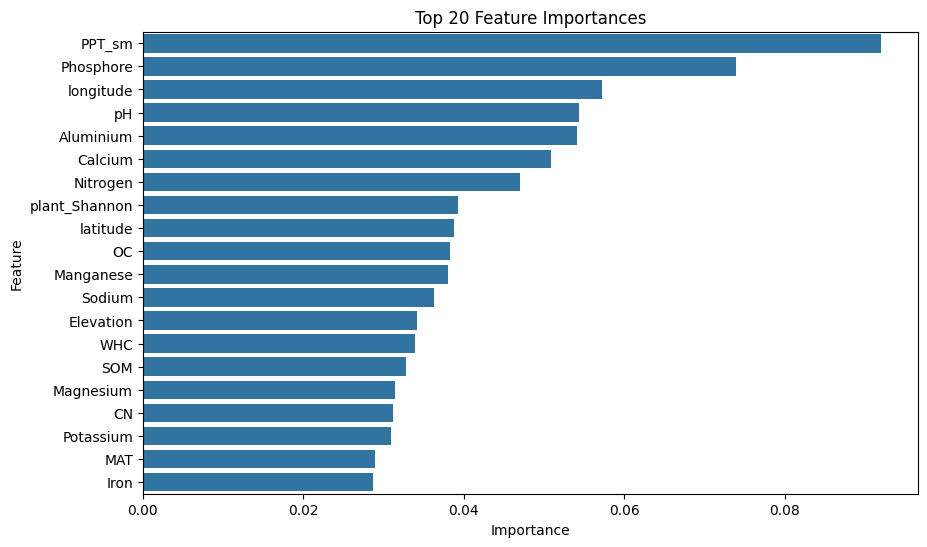

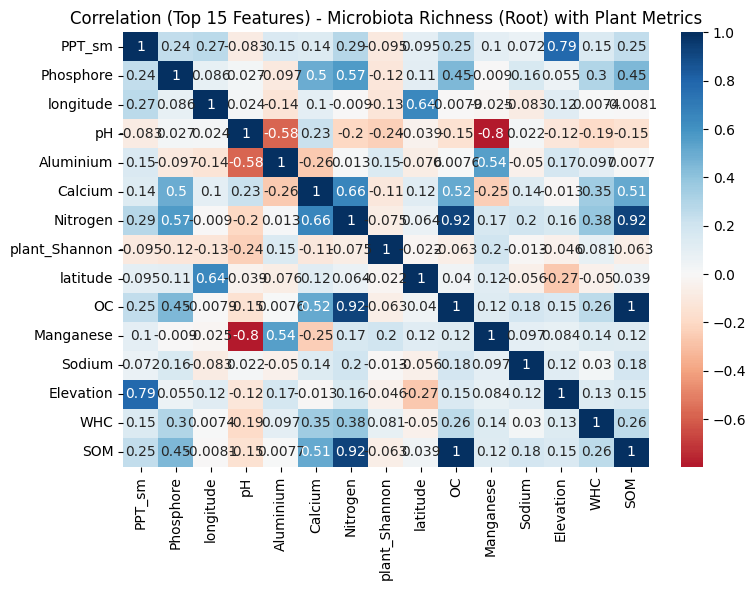


Dropping feature 'PPT_sm' => measuring test performance difference...
   => Original R2: 0.082, Dropped R2: 0.098, ΔR² = -0.016
   => Original RMSE: 1.070, Dropped RMSE: 1.061, ΔRMSE = -0.009
   => Repeated-CV: mean R2 diff = 0.059, p-value = 2.148e-06

Dropping feature 'Phosphore' => measuring test performance difference...
   => Original R2: 0.082, Dropped R2: 0.094, ΔR² = -0.012
   => Original RMSE: 1.070, Dropped RMSE: 1.063, ΔRMSE = -0.007
   => Repeated-CV: mean R2 diff = 0.023, p-value = 0.03081

Dropping feature 'longitude' => measuring test performance difference...
   => Original R2: 0.082, Dropped R2: 0.033, ΔR² = 0.049
   => Original RMSE: 1.070, Dropped RMSE: 1.098, ΔRMSE = 0.028


In [ ]:
"""
CONDITIONAL INDEPENDENCE TESTING
"""

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import ttest_rel
from google.colab import drive
drive.mount('/content/drive')



def perform_lofo_and_correlation_plots(framework, tasks, top_k_lofo=30, top_k_corr=15,
                                       do_significance_test=True, test_mode=False,
    test_tasks_limit=1, figs_dir='figs'):
    """
    Trains or retrieves models for each 'Richness' task, plots correlation heatmaps,
    performs LOFO, and saves figures in `figs_dir`.

    1) Filter tasks to only those involving 'Richness'.
    2) For each 'Richness' task:
       - Train (or retrieve) a RandomForest model on *all* features, get baseline performance.
       - Determine top_k_corr features => plot correlation heatmap.
       - Then do LOFO on top_k_lofo features => check performance drop
         AND optionally call lofo_significance_test for repeated-CV p-value.
    3) Return a dictionary with LOFO results for each task.
    """

    # Ensure the directory to store figures exists
    if not os.path.exists(figs_dir):
        os.makedirs(figs_dir)


    # If test_mode, slice the tasks dictionary
    if test_mode:
        # convert tasks to list and slice
        subset_task_names = list(tasks.keys())[:test_tasks_limit]
        tasks = {k: tasks[k] for k in subset_task_names}
        print(f"[TEST MODE] Only running LOFO on the first {test_tasks_limit} tasks.")


    # Identify tasks that have 'Richness'
    richness_tasks = {
        t_name: t_info
        for t_name, t_info in tasks.items()
        if "Richness" in t_name or "richness" in t_info['target']
    }

    lofo_results = {}
    correlation_figs = {}  # new dictionary to store figure paths
    feature_importance_figs = {}
    dataset_sizes = {}


    for task_name, task_info in richness_tasks.items():
        print(f"\n=== LOFO & Correlation Plot for {task_name} ===")

        target = task_info['target']
        all_features = task_info['features']

        # Prepare data
        X_full = framework.data[all_features]  # entire dataset
        y_full = framework.data[target]

        # Use your pipeline's method
        X_train, X_test, y_train, y_test = framework.impute_or_drop(X_full, y_full)


        # Record dataset size (rows, columns) for this task
        num_rows, num_cols = X_train.shape
        dataset_sizes[task_name] = (num_rows, num_cols + 1)  # +1 to count the target column if you wish


        # Train a baseline model on the training set
        model = RandomForestRegressor(
            n_estimators=400,
            random_state=42,
            max_features='sqrt',
            oob_score=True,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=3
        )
        model.fit(X_train, y_train)

        # Baseline performance on the test set
        y_pred_test = model.predict(X_test)
        baseline_r2 = r2_score(y_test, y_pred_test)
        baseline_rmse = sqrt(mean_squared_error(y_test, y_pred_test))

        # Get feature importances
        importance_df = framework.analyze_feature_importance(model, all_features)
        importance_df = importance_df.sort_values("Importance", ascending=False)

        # -----------------------------------------------------
        # Plot & save a bar chart of feature importance
        # -----------------------------------------------------
        plt.figure(figsize=(6, 4))
        sns.barplot(x="Importance", y="Feature", data=importance_df.head(15))  # top 15 or all
        plt.title(f"Importance - {task_name}")
        plt.tight_layout()

        # Build a safe filename
        safe_task_name = task_name.replace(" ", "_").replace("(", "").replace(")", "").replace("/", "")
        featimp_filename = f"{safe_task_name}_feature_importance.png"
        featimp_path = os.path.join(figs_dir, featimp_filename)

        plt.savefig(featimp_path, dpi=150)
        plt.close()

        # Store path
        feature_importance_figs[task_name] = featimp_path


        # Plot Correlation Heatmap for Top k
        top_features_for_corr = importance_df.head(top_k_corr)['Feature'].tolist()
        top_features_for_corr = [f for f in top_features_for_corr if f in X_train.columns]

        corr_matrix = X_train[top_features_for_corr].corr()

        plt.figure(figsize=(8,6))
        sns.heatmap(corr_matrix, annot=True, cmap='RdBu', center=0)
        plt.title(f"Correlation (Top {top_k_corr} Features) - {task_name}")
        plt.tight_layout()

        # 1) Construct a filename
        safe_task_name = task_name.replace(" ", "_").replace("(", "").replace(")", "").replace("/", "")
        fig_filename = f"{safe_task_name}_corr_heatmap.png"
        fig_path = os.path.join(figs_dir, fig_filename)

        # 2) Save figure
        plt.savefig(fig_path, dpi=150)

        # Then display (optional)
        plt.show()

        # Close if you want to free memory
        plt.close()

        # 3) Store path for this task
        correlation_figs[task_name] = fig_path


        # 2) LOFO for Top top_k_lofo
        top_features_for_lofo = importance_df.head(top_k_lofo)['Feature'].tolist()

        lofo_result_for_task = {
            "Baseline R2": baseline_r2,
            "Baseline RMSE": baseline_rmse,
            "Feature_Drops": []
        }

        for feat in top_features_for_lofo:
            print(f"\nDropping feature '{feat}' => measuring test performance difference...")

            # Drop from X_train / X_test
            X_train_drop = X_train.drop(columns=[feat], errors='ignore')
            X_test_drop = X_test.drop(columns=[feat], errors='ignore')

            model_drop = RandomForestRegressor(
                n_estimators=400,
                random_state=42,
                max_features='sqrt',
                oob_score=True,
                max_depth=10,
                min_samples_split=5,
                min_samples_leaf=3
            )
            model_drop.fit(X_train_drop, y_train)

            y_pred_drop = model_drop.predict(X_test_drop)
            drop_r2 = r2_score(y_test, y_pred_drop)
            drop_rmse = sqrt(mean_squared_error(y_test, y_pred_drop))

            r2_diff = baseline_r2 - drop_r2
            rmse_diff = drop_rmse - baseline_rmse

            print(f"   => Original R2: {baseline_r2:.3f}, Dropped R2: {drop_r2:.3f}, ΔR² = {r2_diff:.3f}")
            print(f"   => Original RMSE: {baseline_rmse:.3f}, Dropped RMSE: {drop_rmse:.3f}, ΔRMSE = {rmse_diff:.3f}")

            # (Optional) => Repeated-CV significance test
            if do_significance_test:
                # Decide on whether to pass X_full,y_full or X_train,y_train
                # Usually repeated CV is done on the entire dataset.
                # Here we do it on the training set only, but either is possible.
                sig_result = lofo_significance_test(
                    X_train,  # or X_full
                    y_train,  # or y_full
                    feature_to_drop=feat,
                    n_splits=5,
                    n_repeats=3
                )
                p_val = sig_result['p_val']
                mean_diff_cv = sig_result['mean_diff']
                print(f"   => Repeated-CV: mean R2 diff = {mean_diff_cv:.3f}, p-value = {p_val:.4g}")
            else:
                p_val = None
                mean_diff_cv = None

            lofo_result_for_task["Feature_Drops"].append({
                "feature": feat,
                "Test_R2_after_drop": drop_r2,
                "Test_R2_diff": r2_diff,
                "Test_RMSE_after_drop": drop_rmse,
                "Test_RMSE_diff": rmse_diff,
                "RepeatedCV_mean_diff": mean_diff_cv,
                "RepeatedCV_p_value": p_val
            })

        lofo_results[task_name] = lofo_result_for_task

    return lofo_results, correlation_figs, dataset_sizes, feature_importance_figs




def lofo_significance_test(X, y, feature_to_drop, n_splits=5, n_repeats=3):
    """
    Perform a LOFO test for 'feature_to_drop' using repeated CV and
    return the mean R² difference and a p-value from a paired t-test.

    - X, y: the entire dataset on which to do cross-validation
    - feature_to_drop: the name of the feature we drop
    - n_splits: number of folds for cross-validation
    - n_repeats: how many times to repeat with different random seeds
    """
    r2_full_scores = []
    r2_drop_scores = []

    # Setup repeated K-fold
    for random_seed in range(n_repeats):
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42 + random_seed)

        for train_idx, test_idx in kf.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            # --- Full model ---
            model_full = RandomForestRegressor(
                n_estimators=400,
                random_state=42,
                max_features='sqrt',
                max_depth=10,
                min_samples_split=5,
                min_samples_leaf=3
            )
            model_full.fit(X_train, y_train)
            y_pred_full = model_full.predict(X_test)
            r2_full = r2_score(y_test, y_pred_full)
            r2_full_scores.append(r2_full)

            # --- Dropped-feature model ---
            X_train_dropped = X_train.drop(columns=[feature_to_drop], errors='ignore')
            X_test_dropped = X_test.drop(columns=[feature_to_drop], errors='ignore')

            model_drop = RandomForestRegressor(
                n_estimators=400,
                random_state=42,
                max_features='sqrt',
                max_depth=10,
                min_samples_split=5,
                min_samples_leaf=3
            )
            model_drop.fit(X_train_dropped, y_train)
            y_pred_drop = model_drop.predict(X_test_dropped)
            r2_drop = r2_score(y_test, y_pred_drop)
            r2_drop_scores.append(r2_drop)

    r2_full_scores = np.array(r2_full_scores)
    r2_drop_scores = np.array(r2_drop_scores)

    # Compute the differences
    r2_diff = r2_full_scores - r2_drop_scores  # if positive => full model does better
    mean_diff = np.mean(r2_diff)

    # Paired t-test
    t_stat, p_val = ttest_rel(r2_full_scores, r2_drop_scores)

    return {
        'mean_diff': mean_diff,
        'p_val': p_val,
        'full_model_mean_r2': np.mean(r2_full_scores),
        'drop_model_mean_r2': np.mean(r2_drop_scores),
        'n_splits': n_splits,
        'n_repeats': n_repeats
    }




import os
from pptx import Presentation
from pptx.util import Inches, Pt
from pptx.enum.text import PP_ALIGN

def create_powerpoint_report(
    lofo_results,
    correlation_figs=None,
    dataset_sizes=None,
    feature_importance_figs=None,
    output_pptx='report.pptx'
):
    """
    Create a PowerPoint presentation summarizing LOFO, correlation heatmaps,
    and partial correlation results (if provided).

    :param lofo_results: dict with LOFO results. See example structure above.
    :param correlation_figs: dict mapping task_name -> path_to_corr_figure.png
    :param partial_corr_results: dict mapping task_name -> list of partial corr dicts
    :param output_pptx: str, path to save the output PPTX file.
    """

    prs = Presentation()

    # (1) Title Slide (layout index 0)
    title_slide_layout = prs.slide_layouts[0]
    slide = prs.slides.add_slide(title_slide_layout)
    slide.shapes.title.text = "Ecodynamics AI - Models Results"
    slide.placeholders[1].text = "Data Analysis"

    # (2) Dataset Sizes Slide
    # layout index 1 is usually "Title and Content"
    bullet_slide_layout = prs.slide_layouts[1]
    ds_slide = prs.slides.add_slide(bullet_slide_layout)
    ds_slide.shapes.title.text = "Dataset Sizes"

    ds_body = ds_slide.shapes.placeholders[1].text_frame
    ds_body.text = "Each task uses a dataset with the following shape(X_train):\n"

    for task_name, (rows, cols) in dataset_sizes.items():
        p = ds_body.add_paragraph()
        p.level = 1
        p.text = f"{task_name}: {rows} rows, {cols} columns"

    # (3) Feature Importance Slides
    # layout index 5 might be "Title Only" or blank
    image_slide_layout = prs.slide_layouts[5]
    for task_name, fig_path in feature_importance_figs.items():
        if not os.path.exists(fig_path):
            print(f"[WARNING] Feature Importance file not found: {fig_path}")
            continue

        slide_fi = prs.slides.add_slide(image_slide_layout)
        slide_fi.shapes.title.text = f"Feature Importance: {task_name}"

        left = Inches(1)
        top = Inches(1.5)
        height = Inches(4)

        slide_fi.shapes.add_picture(fig_path, left, top, height=height)

    # (4) LOFO Results Slides
    # We'll reuse layout index 1 for bullets
    for task_name, lofo_data in lofo_results.items():
        slide_lofo = prs.slides.add_slide(bullet_slide_layout)
        slide_lofo.shapes.title.text = f"LOFO(leave-one-feature-out) Results: {task_name}"

        tf_lofo = slide_lofo.shapes.placeholders[1].text_frame
        #baseline_r2 = lofo_data["Baseline R2"]
        baseline_rmse = lofo_data["Baseline RMSE"]
        #tf_lofo.text = f"Baseline R²: {baseline_r2:.3f}, Baseline RMSE: {baseline_rmse:.3f}"
        tf_lofo.text = f"Baseline RMSE: {baseline_rmse:.3f}"


        # List feature drops
        drops = lofo_data["Feature_Drops"]
        for drop_info in drops:
            p = tf_lofo.add_paragraph()
            p.level = 1

            feat = drop_info["feature"]
            rmse_diff = drop_info["Test_RMSE_diff"]  # e.g. +0.007
            rmse_after = drop_info["Test_RMSE_after_drop"]  # e.g. 1.060

            # If you have repeated CV stats
            cv_diff = drop_info.get("RepeatedCV_mean_diff", None)
            p_val = drop_info.get("RepeatedCV_p_value", None)

            # Build the text string
            text_str = (f"Drop '{feat}' => "
                        f"RMSE diff: {rmse_diff:+.3f} "
                        f"(RMSE after drop: {rmse_after:.3f})")

            # If repeated CV info is available, append it
            if cv_diff is not None and p_val is not None:
                # e.g. "| CV diff = +0.054, p = 4.261e-07"
                #text_str += f" | CV diff = {cv_diff:+.3f}, p = {p_val:.3g}"
                text_str += f" | p = {p_val:.3g}"

            p.text = text_str

    # (5) Correlation Heatmaps Slides
    # Same approach
    for task_name, fig_path in correlation_figs.items():
        if not os.path.exists(fig_path):
            print(f"[WARNING] Correlation fig not found: {fig_path}")
            continue

        slide_corr = prs.slides.add_slide(image_slide_layout)
        slide_corr.shapes.title.text = f"Correlation Heatmap (Top-10): {task_name}"

        left = Inches(1)
        top = Inches(1.5)
        height = Inches(4)

        slide_corr.shapes.add_picture(fig_path, left, top, height=height)

    # (6) Save the PPTX
    prs.save(output_pptx)
    print(f"PowerPoint saved to {output_pptx}")




lofo_results, correlation_figs, dataset_sizes, feature_importance_figs = perform_lofo_and_correlation_plots(framework, tasks,
    top_k_lofo=30,
    top_k_corr=15,
    do_significance_test=True,
    test_mode=False
)



create_powerpoint_report(
    lofo_results=lofo_results,
    correlation_figs=correlation_figs,
    dataset_sizes=dataset_sizes,
    feature_importance_figs=feature_importance_figs,
    output_pptx="final_analysis_report.pptx"
)




# This will:
# 1) Train models for each Richness task
# 2) Plot correlation for the top 10 features
# 3) Run LOFO on the top 5 features
# 4) For each feature drop, do a repeated CV LOFO significance test
# 5) Return a dictionary with all the results

In [ ]:
correlation_figs

{'Microbiota Richness (Root) with Plant OTUs': 'figs/Microbiota_Richness_Root_with_Plant_OTUs_corr_heatmap.png'}

In [ ]:
%pip install python-pptx
#framework.display_results()

"""Print the results in a nice-looking table for a PowerPoint presentation."""
table_data = []
headers = ["Task", "RMSE (Train)", "RMSE (Test)", "Linear RMSE (Train)", "Linear RMSE (Test)", "Standard Deviation Y test", "Top-k RMSE (Train)", "Top-k RMSE (Test)"]



for task_name, metrics in framework.results.items():
    table_data.append([
        task_name,
        f"{metrics['RMSE (Train)']:.3f}",
        f"{metrics['RMSE (Test)']:.3f}",
        f"{metrics['Linear RMSE (Train)']:.3f}",
        f"{metrics['Linear RMSE (Test)']:.3f}",
        f"{metrics['Standard Deviation Y test']:.3f}",
        f"{metrics['Top-k RMSE (Train)']:.3f}",
        f"{metrics['Top-k RMSE (Test)']:.3f}"
    ])

# print(tabulate(table_data, headers=headers, tablefmt="grid"))


# framework.print_results_table()

from pptx import Presentation
from pptx.util import Inches
from pptx.dml.color import RGBColor
from pptx.oxml import parse_xml

# Create PowerPoint presentation
prs = Presentation()
slide_layout = prs.slide_layouts[5]  # Blank slide layout
slide = prs.slides.add_slide(slide_layout)

# Prepare data (using your existing variables)
combined_data = [headers] + table_data  # Include headers as first row

# Calculate table dimensions
rows = len(combined_data)
cols = len(headers)

# Create table (position and size)
left = Inches(0.5)
top = Inches(1)
width = Inches(9)  # Slide width is typically 13.33", adjust as needed
height = Inches(0.5)
table_shape = slide.shapes.add_table(rows, cols, left, top, width, height)
table = table_shape.table

# Populate table with styling
for row_idx, row in enumerate(combined_data):
    for col_idx, value in enumerate(row):
        cell = table.cell(row_idx, col_idx)
        cell.text = str(value)

        # Style header row
        if row_idx == 0:
            cell.fill.solid()
            cell.fill.fore_color.rgb = RGBColor(59, 89, 152)  # Blue header
            paragraph = cell.text_frame.paragraphs[0]
            paragraph.font.color.rgb = RGBColor(255, 255, 255)  # White text
            paragraph.font.bold = True

# Auto-adjust column widths (percentage-based)
col_widths = [1.5, 1.0, 1.0, 1.2, 1.2, 1.5, 1.2, 1.2]  # Relative widths
total_width = sum(col_widths)
for col_idx, width in enumerate(col_widths):
    table.columns[col_idx].width = Inches(width * (9 / total_width))  # 9" total width

# Add slide title
title_shape = slide.shapes.add_textbox(Inches(0.5), Inches(0.2), Inches(9), Inches(0.5))
title_frame = title_shape.text_frame
title_frame.text = "Model Performance Metrics"
title_frame.paragraphs[0].font.bold = True
title_frame.paragraphs[0].font.size = Inches(0.2)

# Save presentation
prs.save("model_performance.pptx")
print("PowerPoint table created successfully!")

In [ ]:
#Scale and Input -- slightly better

--- Training Model for Microbiota Richness (Root) with Plant OTUs ---
Training data scaled shape: (127, 67)
Test data scaled shape: (32, 67)
Training data shape after imputation: (127, 67)
Test data shape after imputation: (32, 67)
R2 (Train): 0.8684509417438899
MSE (Train): 0.29363194025598244
R2 (Test): 0.15825055037226876
MSE (Test): 1.0501111658428786
OOB Score: 0.01636670165686105
Correlation Coefficient: 0.430327412716056

--- Training Model for Microbiota Richness (Leaf) with Plant OTUs ---
Training data scaled shape: (124, 67)
Test data scaled shape: (32, 67)
Training data shape after imputation: (124, 67)
Test data shape after imputation: (32, 67)
R2 (Train): 0.8565940297708485
MSE (Train): 0.2769779657984198
R2 (Test): -0.09501800728465293
MSE (Test): 1.9399713307357505
OOB Score: -0.060900056120134494
Correlation Coefficient: -0.07905287641131653

--- Training Model for Microbiota Richness (Root) with Plant Metrics ---
Training data scaled shape: (127, 25)
Test data scaled shape: (32, 25)
Training data shape after imputation: (127, 25)
Test data shape after imputation: (32, 25)
R2 (Train): 0.8752756545060862
MSE (Train): 0.27839843211370424
R2 (Test): 0.1198801372229441
MSE (Test): 1.09797956576156
OOB Score: 0.06553170395148045
Correlation Coefficient: 0.3911257277666242

--- Training Model for Microbiota Richness (Leaf) with Plant Metrics ---
Training data scaled shape: (124, 25)
Test data scaled shape: (32, 25)
Training data shape after imputation: (124, 25)
Test data shape after imputation: (32, 25)
R2 (Train): 0.8591818620174699
MSE (Train): 0.27197976028193105
R2 (Test): -0.14523882984575875
MSE (Test): 2.02894425659302
OOB Score: -0.046820389460780154
Correlation Coefficient: -0.14225732022116427

--- Training Model for Microbiota Shannon (Root) with Plant OTUs ---
Training data scaled shape: (127, 67)
Test data scaled shape: (32, 67)
Training data shape after imputation: (127, 67)
Test data shape after imputation: (32, 67)
R2 (Train): 0.8695403849082675
MSE (Train): 0.014659993183488007
R2 (Test): -0.18186907487196668
MSE (Test): 0.07573725580122936
OOB Score: 0.0034981693537382563
Correlation Coefficient: 0.046347776365608134

--- Training Model for Microbiota Shannon (Leaf) with Plant OTUs ---
Training data scaled shape: (124, 67)
Test data scaled shape: (32, 67)
Training data shape after imputation: (124, 67)
Test data shape after imputation: (32, 67)
R2 (Train): 0.8637288789660391
MSE (Train): 0.007552408481106395
R2 (Test): -0.17154988685469386
MSE (Test): 0.06585050023028818
OOB Score: 0.027177420000899843
Correlation Coefficient: -0.29083989379354547

--- Training Model for Microbiota Shannon (Root) with Plant Metrics ---
Training data scaled shape: (127, 25)
Test data scaled shape: (32, 25)
Training data shape after imputation: (127, 25)
Test data shape after imputation: (32, 25)
R2 (Train): 0.8784444003052997
MSE (Train): 0.013659432167464923
R2 (Test): 0.01256712014859962
MSE (Test): 0.06327727681338281
OOB Score: 0.07600988195358527
Correlation Coefficient: 0.29300018899611285

--- Training Model for Microbiota Shannon (Leaf) with Plant Metrics ---
Training data scaled shape: (124, 25)
Test data scaled shape: (32, 25)
Training data shape after imputation: (124, 25)
Test data shape after imputation: (32, 25)
R2 (Train): 0.8639139574631655
MSE (Train): 0.00754215107366187
R2 (Test): -0.13866972961491086
MSE (Test): 0.06400237167325065
OOB Score: 0.012529481812172505
Correlation Coefficient: -0.19336577199712085

--- Training Model for Pathobiota Richness (Root) with Plant OTUs ---
Training data scaled shape: (110, 67)
Test data scaled shape: (28, 67)
Training data shape after imputation: (110, 67)
Test data shape after imputation: (28, 67)
R2 (Train): 0.8685539631988054
MSE (Train): 0.0054535763815690965
R2 (Test): -0.015608693688900166
MSE (Test): 0.05260994376541967
OOB Score: -0.05529251162785864
Correlation Coefficient: 0.1090284826276948

--- Training Model for Pathobiota Richness (Leaf) with Plant OTUs ---
Training data scaled shape: (124, 67)
Test data scaled shape: (31, 67)
Training data shape after imputation: (124, 67)
Test data shape after imputation: (31, 67)
R2 (Train): 0.8594888265285523
MSE (Train): 0.041855901246450354
R2 (Test): 0.1397127568303569
MSE (Test): 0.2095731848231524
OOB Score: -0.01783343390809966
Correlation Coefficient: 0.46131606410913323

--- Training Model for Pathobiota Richness (Root) with Plant Metrics ---
Training data scaled shape: (110, 25)
Test data scaled shape: (28, 25)
Training data shape after imputation: (110, 25)
Test data shape after imputation: (28, 25)
R2 (Train): 0.8643066124820343
MSE (Train): 0.005629795095475676
R2 (Test): -0.08920251845409877
MSE (Test): 0.05642220630948691
OOB Score: -0.08401995635922455
Correlation Coefficient: 0.018568975587560585

--- Training Model for Pathobiota Richness (Leaf) with Plant Metrics ---
Training data scaled shape: (124, 25)
Test data scaled shape: (31, 25)
Training data shape after imputation: (124, 25)
Test data shape after imputation: (31, 25)
R2 (Train): 0.8647477152562107
MSE (Train): 0.040289367270448295
R2 (Test): 0.11526217950239581
MSE (Test): 0.21552955044645983
OOB Score: 0.02384848419740515
Correlation Coefficient: 0.4262858463251791

--- Training Model for Pathobiota Shannon (Root) with Plant OTUs ---
Training data scaled shape: (110, 67)
Test data scaled shape: (28, 67)
Training data shape after imputation: (110, 67)
Test data shape after imputation: (28, 67)
R2 (Train): 0.8727007478498761
MSE (Train): 0.001589643083914407
R2 (Test): -0.03578036060473688
MSE (Test): 0.013686234741249323
OOB Score: 0.026726317959398838
Correlation Coefficient: 0.08911450828367803

--- Training Model for Pathobiota Shannon (Leaf) with Plant OTUs ---
Training data scaled shape: (124, 67)
Test data scaled shape: (31, 67)
Training data shape after imputation: (124, 67)
Test data shape after imputation: (31, 67)
R2 (Train): 0.8644997340015919
MSE (Train): 0.0030254133354992684
R2 (Test): -0.20173032191565565
MSE (Test): 0.015335921159907135
OOB Score: -0.0017705463831141355
Correlation Coefficient: 0.057859106731347774

--- Training Model for Pathobiota Shannon (Root) with Plant Metrics ---
Training data scaled shape: (110, 25)
Test data scaled shape: (28, 25)
Training data shape after imputation: (110, 25)
Test data shape after imputation: (28, 25)
R2 (Train): 0.8687182955914952
MSE (Train): 0.001639373758546248
R2 (Test): -0.031992045856047424
MSE (Test): 0.013636178023728603
OOB Score: -0.006868174599617971
Correlation Coefficient: 0.12285544217563377

--- Training Model for Pathobiota Shannon (Leaf) with Plant Metrics ---
Training data scaled shape: (124, 25)
Test data scaled shape: (31, 25)
Training data shape after imputation: (124, 25)
Test data shape after imputation: (31, 25)
R2 (Train): 0.8686888616950631
MSE (Train): 0.0029318796240002383
R2 (Test): -0.21549473140090036
MSE (Test): 0.015511576125774931
OOB Score: 0.022863802771192376
Correlation Coefficient: 0.12357669812280478



# DROP
--- Training Model for Microbiota Richness (Root) with Plant OTUs ---
Training data shape after dropping missing values: (110, 67)
Test data shape after dropping missing values: (28, 67)
R2 (Train): 0.8612189704466142
MSE (Train): 0.30262927919664445
R2 (Test): 0.1574426965552791
MSE (Test): 1.0157216668019184
OOB Score: 0.0005939328094681784
Correlation Coefficient: 0.4127784585749283

--- Training Model for Microbiota Richness (Leaf) with Plant OTUs ---
Training data shape after dropping missing values: (108, 67)
Test data shape after dropping missing values: (27, 67)
R2 (Train): 0.8620658280899647
MSE (Train): 0.27653322924193435
R2 (Test): -0.10217404724210555
MSE (Test): 1.774899369542158
OOB Score: -0.037814833364959055
Correlation Coefficient: -0.010263502689184762

--- Training Model for Microbiota Richness (Root) with Plant Metrics ---
Training data shape after dropping missing values: (110, 25)
Test data shape after dropping missing values: (28, 25)
R2 (Train): 0.860897298681507
MSE (Train): 0.3033307244498293
R2 (Test): 0.0704488518172054
MSE (Test): 1.1205946916010687
OOB Score: -0.006344772955906963
Correlation Coefficient: 0.28940324463933215

--- Training Model for Microbiota Richness (Leaf) with Plant Metrics ---
Training data shape after dropping missing values: (108, 25)
Test data shape after dropping missing values: (27, 25)
R2 (Train): 0.8542926833318278
MSE (Train): 0.29211698772300576
R2 (Test): -0.10066678806202423
MSE (Test): 1.7724721364067408
OOB Score: -0.09214649715391987
Correlation Coefficient: 0.05540351893430505

--- Training Model for Microbiota Shannon (Root) with Plant OTUs ---
Training data shape after dropping missing values: (110, 67)
Test data shape after dropping missing values: (28, 67)
R2 (Train): 0.8699785061367991
MSE (Train): 0.012864020605947973
R2 (Test): -0.19271588001501616
MSE (Test): 0.04121419273055716
OOB Score: 0.039323643292506816
Correlation Coefficient: 0.16633406168453074

--- Training Model for Microbiota Shannon (Leaf) with Plant OTUs ---
Training data shape after dropping missing values: (108, 67)
Test data shape after dropping missing values: (27, 67)
R2 (Train): 0.8664166886917224
MSE (Train): 0.006813403475870331
R2 (Test): 0.1309169833883279
MSE (Test): 0.05744817485997224
OOB Score: -0.010726912614949624
Correlation Coefficient: 0.42744679601956004

--- Training Model for Microbiota Shannon (Root) with Plant Metrics ---
Training data shape after dropping missing values: (110, 25)
Test data shape after dropping missing values: (28, 25)
R2 (Train): 0.8727000489727385
MSE (Train): 0.01259475756272891
R2 (Test): -0.3147584185962804
MSE (Test): 0.045431361958111476
OOB Score: 0.049125545356001665
Correlation Coefficient: 0.16396815668185172

--- Training Model for Microbiota Shannon (Leaf) with Plant Metrics ---
Training data shape after dropping missing values: (108, 25)
Test data shape after dropping missing values: (27, 25)
R2 (Train): 0.8668610091934809
MSE (Train): 0.006790740952974074
R2 (Test): 0.08115092112712319
MSE (Test): 0.06073781393038042
OOB Score: -0.00958383374503824
Correlation Coefficient: 0.30896481282092986

--- Training Model for Pathobiota Richness (Root) with Plant OTUs ---
Training data shape after dropping missing values: (94, 67)
Test data shape after dropping missing values: (24, 67)
R2 (Train): 0.8564853699041556
MSE (Train): 0.007221125294964745
R2 (Test): 0.11741284070361435
MSE (Test): 0.03090875228919022
OOB Score: -0.12321270542749518
Correlation Coefficient: 0.3992891913105495

--- Training Model for Pathobiota Richness (Leaf) with Plant OTUs ---
Training data shape after dropping missing values: (107, 67)
Test data shape after dropping missing values: (27, 67)
R2 (Train): 0.8540555869970164
MSE (Train): 0.03356338109862121
R2 (Test): -0.04968747080211822
MSE (Test): 0.3670864937461991
OOB Score: -0.03583215979787391
Correlation Coefficient: 0.04837568226696036

--- Training Model for Pathobiota Richness (Root) with Plant Metrics ---
Training data shape after dropping missing values: (94, 25)
Test data shape after dropping missing values: (24, 25)
R2 (Train): 0.8581423488716133
MSE (Train): 0.007137752242843557
R2 (Test): 0.14565288060190495
MSE (Test): 0.02991976849460502
OOB Score: -0.112169550890171
Correlation Coefficient: 0.40355297719762995

--- Training Model for Pathobiota Richness (Leaf) with Plant Metrics ---
Training data shape after dropping missing values: (107, 25)
Test data shape after dropping missing values: (27, 25)
R2 (Train): 0.8495265514103673
MSE (Train): 0.03460494030788547
R2 (Test): -0.036155769245257874
MSE (Test): 0.3623543186778122
OOB Score: -0.07161735076558995
Correlation Coefficient: 0.12990398048129403

--- Training Model for Pathobiota Shannon (Root) with Plant OTUs ---
Training data shape after dropping missing values: (94, 67)
Test data shape after dropping missing values: (24, 67)
R2 (Train): 0.8546318329137798
MSE (Train): 0.0020182947408605477
R2 (Test): 0.06108207793307174
MSE (Test): 0.01043038675346999
OOB Score: -0.07454683231288572
Correlation Coefficient: 0.2642756658157044

--- Training Model for Pathobiota Shannon (Leaf) with Plant OTUs ---
Training data shape after dropping missing values: (107, 67)
Test data shape after dropping missing values: (27, 67)
R2 (Train): 0.8623498297537079
MSE (Train): 0.0026302923328911662
R2 (Test): -0.07718886096611621
MSE (Test): 0.010452950600891965
OOB Score: -0.007670551684729965
Correlation Coefficient: -0.013090984995069967

--- Training Model for Pathobiota Shannon (Root) with Plant Metrics ---
Training data shape after dropping missing values: (94, 25)
Test data shape after dropping missing values: (24, 25)
R2 (Train): 0.8501528821149917
MSE (Train): 0.002080480589543673
R2 (Test): 0.058394970101387944
MSE (Test): 0.010460237684285155
OOB Score: -0.1046685869514481
Correlation Coefficient: 0.25559100172787097

--- Training Model for Pathobiota Shannon (Leaf) with Plant Metrics ---
Training data shape after dropping missing values: (107, 25)
Test data shape after dropping missing values: (27, 25)
R2 (Train): 0.8619927822920301
MSE (Train): 0.002637114984830127
R2 (Test): -0.20146722004977735
MSE (Test): 0.011658937401661795
OOB Score: -0.008376008339970431
Correlation Coefficient: -0.07230054021074585




# IMPUTATION

--- Training Model for Microbiota Richness (Root) with Plant OTUs ---
Training data shape after imputation: (127, 67)
Test data shape after imputation: (32, 67)
R2 (Train): 0.8696332741193795
MSE (Train): 0.29099284459049624
R2 (Test): 0.11820818521782195
MSE (Test): 1.1000653829487392
OOB Score: 0.02340820252085407
Correlation Coefficient: 0.36731075986231393

--- Training Model for Microbiota Richness (Leaf) with Plant OTUs ---
Training data shape after imputation: (124, 67)
Test data shape after imputation: (32, 67)
R2 (Train): 0.8611522404575566
MSE (Train): 0.2681741208701535
R2 (Test): -0.07544323140424658
MSE (Test): 1.9052919886966797
OOB Score: -0.026295295622795534
Correlation Coefficient: -0.020585203168547197

--- Training Model for Microbiota Richness (Root) with Plant Metrics ---
Training data shape after imputation: (127, 25)
Test data shape after imputation: (32, 25)
R2 (Train): 0.8761573488757173
MSE (Train): 0.27643039348310067
R2 (Test): 0.13962348534143865
MSE (Test): 1.0733490651778967
OOB Score: 0.07210804842847174
Correlation Coefficient: 0.4081168633762274

--- Training Model for Microbiota Richness (Leaf) with Plant Metrics ---
Training data shape after imputation: (124, 25)
Test data shape after imputation: (32, 25)
R2 (Train): 0.8550164912621037
MSE (Train): 0.2800248640999522
R2 (Test): -0.09322614046630417
MSE (Test): 1.9367967982322045
OOB Score: -0.0756820896513355
Correlation Coefficient: 0.009464285045001498

--- Training Model for Microbiota Shannon (Root) with Plant OTUs ---
Training data shape after imputation: (127, 67)
Test data shape after imputation: (32, 67)
R2 (Train): 0.8698875176991788
MSE (Train): 0.01462098521657849
R2 (Test): -0.05971618274411683
MSE (Test): 0.06790937957141163
OOB Score: 0.013682387126631723
Correlation Coefficient: 0.10481335335838646

--- Training Model for Microbiota Shannon (Leaf) with Plant OTUs ---
Training data shape after imputation: (124, 67)
Test data shape after imputation: (32, 67)
R2 (Train): 0.8670734448796249
MSE (Train): 0.007367046184386974
R2 (Test): -0.1172651363059698
MSE (Test): 0.06279926185058335
OOB Score: 0.04652352741001464
Correlation Coefficient: -0.15026284561757863

--- Training Model for Microbiota Shannon (Root) with Plant Metrics ---
Training data shape after imputation: (127, 25)
Test data shape after imputation: (32, 25)
R2 (Train): 0.8789677397049174
MSE (Train): 0.01360062353135442
R2 (Test): 0.008031264994719955
MSE (Test): 0.06356794625331542
OOB Score: 0.07911076219018309
Correlation Coefficient: 0.29363240953930375

--- Training Model for Microbiota Shannon (Leaf) with Plant Metrics ---
Training data shape after imputation: (124, 25)
Test data shape after imputation: (32, 25)
R2 (Train): 0.8628742990849788
MSE (Train): 0.0075997709471412505
R2 (Test): -0.10406967237014242
MSE (Test): 0.062057570941220705
OOB Score: 0.009168229090094737
Correlation Coefficient: -0.0862991565636284

--- Training Model for Pathobiota Richness (Root) with Plant OTUs ---
Training data shape after imputation: (110, 67)
Test data shape after imputation: (28, 67)
R2 (Train): 0.8639940244388915
MSE (Train): 0.005642764088765469
R2 (Test): -0.008947715093082786
MSE (Test): 0.052264895804008706
OOB Score: -0.08764145302753623
Correlation Coefficient: 0.12030478460694993

--- Training Model for Pathobiota Richness (Leaf) with Plant OTUs ---
Training data shape after imputation: (124, 67)
Test data shape after imputation: (31, 67)
R2 (Train): 0.8615671980998196
MSE (Train): 0.04123678951966607
R2 (Test): 0.09686842336046086
MSE (Test): 0.22001042365030155
OOB Score: -0.005065687412428188
Correlation Coefficient: 0.43324490966127666

--- Training Model for Pathobiota Richness (Root) with Plant Metrics ---
Training data shape after imputation: (110, 25)
Test data shape after imputation: (28, 25)
R2 (Train): 0.8645135040219589
MSE (Train): 0.005621211353864769
R2 (Test): -0.07640591118679563
MSE (Test): 0.05575932424387986
OOB Score: -0.08261439189354713
Correlation Coefficient: 0.03342020744228706

--- Training Model for Pathobiota Richness (Leaf) with Plant Metrics ---
Training data shape after imputation: (124, 25)
Test data shape after imputation: (31, 25)
R2 (Train): 0.8628773636652333
MSE (Train): 0.040846513364627066
R2 (Test): 0.09796983755511035
MSE (Test): 0.21974210991856274
OOB Score: 0.010829328900948898
Correlation Coefficient: 0.4178054738525441

--- Training Model for Pathobiota Shannon (Root) with Plant OTUs ---
Training data shape after imputation: (110, 67)
Test data shape after imputation: (28, 67)
R2 (Train): 0.8698977656195094
MSE (Train): 0.0016246451851960602
R2 (Test): -0.03505603624207687
MSE (Test): 0.013676663915586649
OOB Score: 0.002476470287102628
Correlation Coefficient: 0.09650938387322787

--- Training Model for Pathobiota Shannon (Leaf) with Plant OTUs ---
Training data shape after imputation: (124, 67)
Test data shape after imputation: (31, 67)
R2 (Train): 0.8672052902656724
MSE (Train): 0.002965004406107285
R2 (Test): -0.2803009725159742
MSE (Test): 0.01633860311035364
OOB Score: 0.011544399131450223
Correlation Coefficient: 0.1252508159469502

--- Training Model for Pathobiota Shannon (Root) with Plant Metrics ---
Training data shape after imputation: (110, 25)
Test data shape after imputation: (28, 25)
R2 (Train): 0.8697077535583015
MSE (Train): 0.0016270179513659907
R2 (Test): -0.05360960165764839
MSE (Test): 0.013921820573525576
OOB Score: 0.00039554760324078675
Correlation Coefficient: 0.08632647143128482

--- Training Model for Pathobiota Shannon (Leaf) with Plant Metrics ---
Training data shape after imputation: (124, 25)
Test data shape after imputation: (31, 25)
R2 (Train): 0.8681163452113028
MSE (Train): 0.002944662617391423
R2 (Test): -0.23259718155199072
MSE (Test): 0.01572982960775437
OOB Score: 0.019327529957543943
Correlation Coefficient: 0.13989252484711429

In [ ]:
# TOP-15 IMPROVES

Analysis of Results with Top-15 Features
Training Performance (Top-k R² Train):

The training performance for the models trained on the top 15 features is consistently high or slightly improved compared to the original models.
For example:
"Microbiota Richness (Root) with Plant OTUs": R² Train improved from 0.868 to 0.874.
"Pathobiota Richness (Leaf) with Plant OTUs": R² Train improved from 0.859 to 0.874.
Test Performance (Top-k R² Test):

Test performance is mixed:
Some tasks showed improvement or marginal changes, such as "Pathobiota Richness (Leaf) with Plant OTUs", where R² Test improved from 0.139 to 0.163.
Others experienced a decline, such as "Microbiota Richness (Root) with Plant OTUs", where R² Test dropped from 0.158 to 0.072.
Out-of-Bag (OOB) Scores (Top-k OOB Score):

OOB scores generally improved across tasks when using the top 15 features.
For example:
"Microbiota Shannon (Root) with Plant OTUs": OOB score improved from 0.003 to 0.146.
"Pathobiota Shannon (Leaf) with Plant OTUs": OOB score improved from -0.001 to 0.121.
This suggests that the top 15 features contribute to better generalization on the training data.
Correlation:

Correlation between predictions and actual values remains poor or slightly negative for many tasks.
For example:
"Microbiota Shannon (Root) with Plant OTUs": Correlation was 0.046 in the original model, but the test R² (-0.03) still indicates poor generalization.
Insights and Recommendations
1. Feature Selection Benefits
The improved OOB scores for many tasks indicate that the top 15 features help reduce overfitting on the training set.
However, the inconsistent test performance highlights that these features alone may not capture all the variability in the test set.
2. Possible Causes of Poor Test Scores
Dataset Size: The dataset may be too small to effectively train a generalizable model, even with feature reduction.
Feature Interactions: Some important interactions between features may be lost when reducing to the top 15.

In [ ]:
Insights
Top-20 Features vs. Top-15 Features:

Top-20 Features perform slightly better in most cases than Top-15, especially in test R² scores.
Adding a few more features (20 instead of 15) helps capture additional variability that might be lost with stricter reduction.
Model Generalization:

Despite better OOB scores, test scores remain low or negative in many tasks. This indicates:
Overfitting: The model may still be overfitting the training data, even with fewer features.
Dataset Limitations: Small dataset size and noise may hinder generalization, regardless of feature selection.
Task-Specific Behavior:

Some tasks (e.g., "Microbiota Richness (Root) with Plant OTUs") benefit from reducing to the top-15 or top-20 features.
Others (e.g., "Microbiota Shannon (Leaf) with Plant Metrics") show little improvement, suggesting these tasks may need alternative approaches like dimensionality reduction (PCA) or different models.


In [ ]:
from google.colab import files
import io
from pprint import pprint
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.impute import KNNImputer

In [ ]:
%pip install --upgrade mlxtend

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 11.1 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.23.3
    Uninstalling mlxtend-0.23.3:
      Successfully uninstalled mlxtend-0.23.3


In [ ]:
#OOB with rmse

import numpy as np
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Generate synthetic data
X, y = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=42)

# Initialize model with OOB enabled
model = RandomForestRegressor(
    n_estimators=100,
    oob_score=True,
    random_state=42
)

# Train the model
model.fit(X, y)

# Compute OOB RMSE
oob_predictions = model.oob_prediction_
oob_rmse = mean_squared_error(y, oob_predictions, squared=False)
print(f"OOB RMSE: {oob_rmse:.4f}")  # Example output: OOB RMSE: 0.1234